![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Joe |
<b>Student-nr</b>: KD6-3.7 |
<b>Date</b>: July 1, 2049
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [207]:
import numpy as np
import pandas as pd
import cv2
import os
import attr
from pathlib import Path
from icecream import ic

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils
from sklearn.metrics import average_precision_score
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

# To visualize your model structure:
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import src.metrics as metrics
import src.utils as utils
from src.descriptor import FacialDescriptor, FeatureDescriptor
from src.dataprocessing import DataPreProcessor

# the following packages are imported when needed throughout this notebook, 
# we are only listing them here so that you can install all necessary packages upfront.
# sklearn
# enum
# scipy
# tensorflow.keras

In [39]:
# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, stratify = y, random_state = 22)

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [40]:
# size of each face after preprocessing
face_size=(47, 47)

In [41]:
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [utils.read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [42]:
# display data structure
# display(data)

### 2. Inspect some images

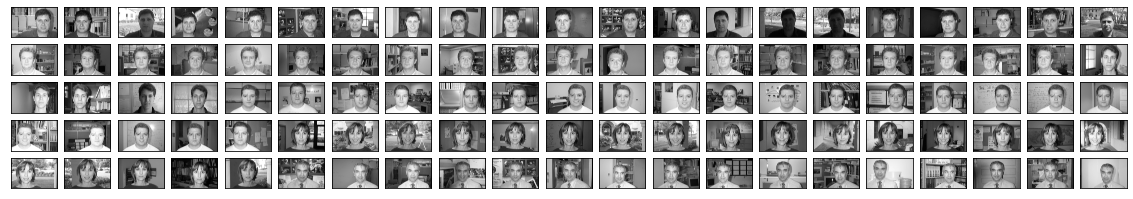

In [43]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [44]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [45]:
feat_data, images, labels = [], [], []

for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

for key in faces.keys():
    print(faces[key][0:2])

[[125  84  55 ...  72  69  81]
 [110  47  24 ...  25  28  49]]
[[[[125]
   [ 84]
   [ 55]
   ...
   [ 88]
   [ 84]
   [ 80]]

  [[118]
   [ 64]
   [ 48]
   ...
   [158]
   [152]
   [ 61]]

  [[ 76]
   [ 68]
   [ 53]
   ...
   [107]
   [114]
   [ 99]]

  ...

  [[ 88]
   [ 98]
   [102]
   ...
   [106]
   [ 85]
   [ 86]]

  [[ 95]
   [ 92]
   [101]
   ...
   [ 83]
   [ 86]
   [112]]

  [[ 81]
   [ 93]
   [ 99]
   ...
   [ 72]
   [ 69]
   [ 81]]]


 [[[110]
   [ 47]
   [ 24]
   ...
   [ 15]
   [ 21]
   [ 24]]

  [[ 86]
   [ 78]
   [ 21]
   ...
   [ 20]
   [ 22]
   [ 20]]

  [[161]
   [122]
   [ 31]
   ...
   [ 17]
   [ 28]
   [ 38]]

  ...

  [[ 99]
   [103]
   [108]
   ...
   [ 19]
   [115]
   [178]]

  [[ 99]
   [102]
   [106]
   ...
   [ 26]
   [ 28]
   [128]]

  [[107]
   [103]
   [ 43]
   ...
   [ 25]
   [ 28]
   [ 49]]]]
['person_001' 'person_001']
[0 0]


### 2. Print statistics of data

In [46]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)
print("imshape : " + str(imshape))

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209
imshape : (47, 47, 1)


### 3. Visualise some faces

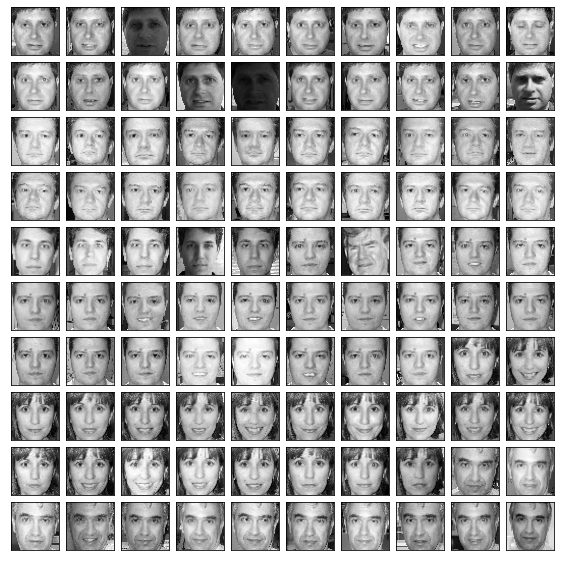

In [47]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [48]:
######################################
# select the technique you want to use
DESC = FeatureDescriptor.PCA
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [49]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded = X_pca
    
    dist_metric = euclidean

num_components 35


### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [50]:
DESC = FeatureDescriptor.LDA

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda
    
    dist_metric = euclidean

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [52]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])
    
    dist_metric = chisquare
    
# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:

def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 







There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [53]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import localmodules.siamese as siamese

In [54]:
encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          894400      ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',       

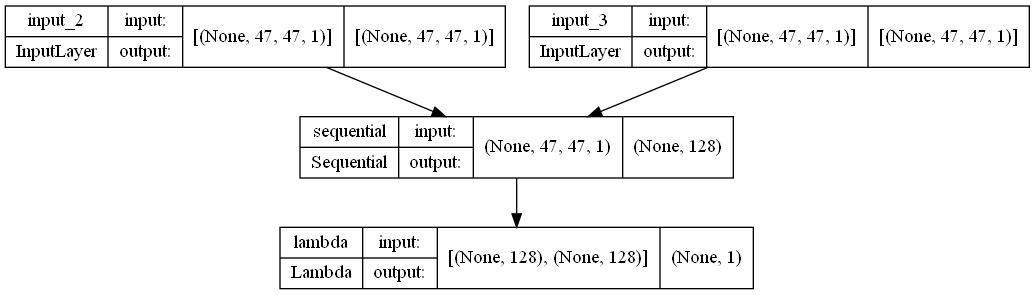

In [55]:
# To visualize your model structure:
plot_model(model, to_file='results/model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [56]:
if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric = euclidean

## IV. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used. 

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting
 

On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score. 

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

For easier use, I created a file containing utils function from the above described facial representations.

In [57]:
facial_descriptor = FacialDescriptor(num_components, faces, n_samples, n_features, n_classes, imshape)

### PCA

In [58]:
embedded_PCA, dist_metric_PCA = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.PCA)
df_scores_PCA, similarity_mat_pca = utils.compute_similarity_matrix(embedded_PCA, dist_metric_PCA, labels)
df_scores_PCA

False
num_components 25


100%|██████████| 440/440 [00:01<00:00, 425.94it/s]


,p1,p2,genuine,score,scores_norm
0,person_001,person_001,1,3.672053,0.837570
1,person_001,person_001,1,6.195196,0.670109
2,person_001,person_001,1,2.996309,0.882419
3,person_001,person_001,1,2.581689,0.909937
4,person_001,person_001,1,4.172084,0.804383
...,...,...,...,...,...
193155,person_026,person_026,1,2.494560,0.915720
193156,person_026,person_026,1,4.421084,0.787857
193157,person_026,person_026,1,4.188316,0.803305
193158,person_026,person_026,1,3.458264,0.851759


In [59]:
face_mat_pca = df_scores_PCA.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_pca

p2,person_001,person_002,person_003,person_004,person_005,person_006,person_007,person_008,person_009,person_010,...,person_017,person_018,person_019,person_020,person_021,person_022,person_023,person_024,person_025,person_026
p1,,,,,,,,,,,,,,,,,,,,,
person_001,0.716324,0.632750,0.592422,0.635268,0.591379,0.598952,0.625639,0.594131,0.564128,0.585301,...,0.570469,0.638796,0.565758,0.574872,0.613146,0.614466,0.569358,0.549873,0.588313,0.664064
person_002,0.632750,0.827400,0.647207,0.717356,0.634535,0.668828,0.698994,0.627824,0.616097,0.646615,...,0.586622,0.704219,0.595833,0.651913,0.689102,0.662537,0.634940,0.579245,0.655175,0.678026
person_003,0.592422,0.647207,0.635106,0.612635,0.574980,0.623498,0.627270,0.575017,0.561888,0.569019,...,0.515495,0.636522,0.598940,0.555429,0.604850,0.592744,0.611729,0.571353,0.600136,0.628641
person_004,0.635268,0.717356,0.612635,0.767000,0.621013,0.633073,0.695887,0.651862,0.584780,0.610132,...,0.552763,0.663615,0.590765,0.630810,0.656530,0.665025,0.634410,0.591713,0.634641,0.656820
person_005,0.591379,0.634535,0.574980,0.621013,0.805201,0.608993,0.634105,0.602587,0.569318,0.573091,...,0.540345,0.647405,0.573430,0.594379,0.628900,0.617480,0.603448,0.553424,0.605800,0.638895
person_006,0.598952,0.668828,0.623498,0.633073,0.608993,0.739399,0.647154,0.619201,0.572913,0.588315,...,0.588337,0.662005,0.599111,0.638721,0.628799,0.642954,0.609812,0.561053,0.616287,0.647543
person_007,0.625639,0.698994,0.627270,0.695887,0.634105,0.647154,0.810064,0.638984,0.606517,0.633346,...,0.537704,0.697603,0.610875,0.617644,0.693314,0.706070,0.627547,0.615212,0.648072,0.670903
person_008,0.594131,0.627824,0.575017,0.651862,0.602587,0.619201,0.638984,0.635500,0.595543,0.610553,...,0.540097,0.628328,0.587216,0.612138,0.616786,0.647073,0.584974,0.606558,0.588270,0.614850
person_009,0.564128,0.616097,0.561888,0.584780,0.569318,0.572913,0.606517,0.595543,0.700932,0.563755,...,0.490168,0.610407,0.543325,0.564196,0.591539,0.594563,0.561936,0.541452,0.573631,0.594871


In [60]:
genuine_df_pca = df_scores_PCA['scores_norm'][df_scores_PCA['genuine'] == 1]
imposter_df_pca = df_scores_PCA['scores_norm'][df_scores_PCA['genuine'] == 0]

print('number of genuine scores : ', len(genuine_df_pca))
print('number of imposter scores : ', len(imposter_df_pca))

number of genuine scores :  8420
number of imposter scores :  184740


### LDA

In [61]:
embedded_LDA, dist_metric_LDA = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.LDA)
df_scores_LDA, similarity_mat_lda = utils.compute_similarity_matrix(embedded_LDA, dist_metric_LDA, labels)
df_scores_LDA

False


100%|██████████| 440/440 [00:01<00:00, 296.70it/s]


,p1,p2,genuine,score,scores_norm
0,person_001,person_001,1,6.255456,0.883117
1,person_001,person_001,1,9.828133,0.775818
2,person_001,person_001,1,7.391354,0.849002
3,person_001,person_001,1,6.824139,0.866038
4,person_001,person_001,1,5.418200,0.908262
...,...,...,...,...,...
193155,person_026,person_026,1,6.303830,0.881664
193156,person_026,person_026,1,6.736131,0.868681
193157,person_026,person_026,1,10.646684,0.751235
193158,person_026,person_026,1,6.811352,0.866422


In [62]:
face_mat_lda = df_scores_LDA.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_lda

p2,person_001,person_002,person_003,person_004,person_005,person_006,person_007,person_008,person_009,person_010,...,person_017,person_018,person_019,person_020,person_021,person_022,person_023,person_024,person_025,person_026
p1,,,,,,,,,,,,,,,,,,,,,
person_001,0.858190,0.482878,0.462904,0.502984,0.228204,0.416450,0.430342,0.391809,0.351576,0.441144,...,0.388686,0.536693,0.485987,0.457285,0.395929,0.489557,0.291416,0.415870,0.425603,0.554358
person_002,0.482878,0.832485,0.498495,0.638965,0.323602,0.512578,0.575778,0.446568,0.376465,0.540354,...,0.387884,0.622386,0.519135,0.558652,0.445136,0.578847,0.312647,0.426370,0.459819,0.545245
person_003,0.462904,0.498495,0.849990,0.477264,0.269576,0.406402,0.461194,0.353388,0.305030,0.430169,...,0.352078,0.532890,0.559944,0.417630,0.389875,0.469492,0.418742,0.407790,0.426794,0.526387
person_004,0.502984,0.638965,0.477264,0.856741,0.291945,0.558653,0.565554,0.535500,0.421481,0.536877,...,0.431008,0.612736,0.544589,0.590406,0.496989,0.639571,0.379460,0.500073,0.490456,0.534651
person_005,0.228204,0.323602,0.269576,0.291945,0.932425,0.268596,0.286351,0.227541,0.200545,0.244506,...,0.172771,0.395382,0.282026,0.268054,0.304034,0.291425,0.165636,0.188706,0.294891,0.346495
person_006,0.416450,0.512578,0.406402,0.558653,0.268596,0.873767,0.438509,0.465734,0.370690,0.464972,...,0.377127,0.534571,0.483640,0.641632,0.366700,0.560025,0.335905,0.410854,0.381203,0.467160
person_007,0.430342,0.575778,0.461194,0.565554,0.286351,0.438509,0.770055,0.412981,0.361837,0.469330,...,0.355401,0.579290,0.505511,0.447072,0.506524,0.631788,0.324352,0.446413,0.460734,0.503919
person_008,0.391809,0.446568,0.353388,0.535500,0.227541,0.465734,0.412981,0.871426,0.450515,0.458460,...,0.323826,0.494625,0.451484,0.494228,0.366625,0.501491,0.301741,0.438013,0.365759,0.399981
person_009,0.351576,0.376465,0.305030,0.421481,0.200545,0.370690,0.361837,0.450515,0.907362,0.379825,...,0.242411,0.422278,0.404066,0.396395,0.321439,0.387960,0.265576,0.362617,0.373566,0.378902


In [63]:
genuine_df_lda = df_scores_LDA['scores_norm'][df_scores_LDA['genuine'] == 1]
imposter_df_lda = df_scores_LDA['scores_norm'][df_scores_LDA['genuine'] == 0]

### LBP

In [64]:
embedded_LBP, dist_metric_LBP = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.LBP)

df_scores_LBP, similarity_mat_lbp = utils.compute_similarity_matrix(embedded_LBP, utils.chi2, labels)
# dist_metric_LBP(embedded_LBP, axis=1).statistic
df_scores_LBP

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


False


100%|██████████| 440/440 [00:01<00:00, 284.79it/s]


,p1,p2,genuine,score,scores_norm
0,person_001,person_001,1,4.817430,0.910841
1,person_001,person_001,1,6.989416,0.693627
2,person_001,person_001,1,5.101078,0.882474
3,person_001,person_001,1,5.110625,0.881519
4,person_001,person_001,1,4.936796,0.898903
...,...,...,...,...,...
193155,person_026,person_026,1,5.213133,0.871268
193156,person_026,person_026,1,5.501838,0.842395
193157,person_026,person_026,1,7.172513,0.675316
193158,person_026,person_026,1,5.262652,0.866316


In [65]:
face_mat_lbp = df_scores_LBP.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_lbp

p2,person_001,person_002,person_003,person_004,person_005,person_006,person_007,person_008,person_009,person_010,...,person_017,person_018,person_019,person_020,person_021,person_022,person_023,person_024,person_025,person_026
p1,,,,,,,,,,,,,,,,,,,,,
person_001,0.770368,0.733379,0.677255,0.713861,0.664364,0.710772,0.552227,0.684709,0.707581,0.693941,...,0.678575,0.695383,0.617632,0.663955,0.699017,0.605285,0.705912,0.634045,0.692627,0.690753
person_002,0.733379,0.827129,0.675055,0.766053,0.708955,0.754482,0.528436,0.727437,0.732913,0.742831,...,0.681709,0.719684,0.619259,0.693652,0.717459,0.582387,0.721856,0.659062,0.728917,0.699910
person_003,0.677255,0.675055,0.743205,0.659172,0.678719,0.696355,0.591677,0.661735,0.717691,0.616054,...,0.633986,0.718174,0.651786,0.625625,0.657700,0.617418,0.713601,0.670756,0.707262,0.669717
person_004,0.713861,0.766053,0.659172,0.825138,0.646241,0.744639,0.570422,0.742507,0.742625,0.744231,...,0.679782,0.707105,0.617862,0.677682,0.695961,0.601683,0.723697,0.671059,0.729595,0.690556
person_005,0.664364,0.708955,0.678719,0.646241,0.846521,0.705222,0.384002,0.649630,0.633678,0.624697,...,0.625457,0.673811,0.596249,0.689378,0.673048,0.456163,0.724241,0.560373,0.640319,0.687538
person_006,0.710772,0.754482,0.696355,0.744639,0.705222,0.781868,0.526414,0.725772,0.723885,0.717212,...,0.705506,0.705506,0.639436,0.712244,0.687211,0.579435,0.733820,0.648044,0.710507,0.680254
person_007,0.552227,0.528436,0.591677,0.570422,0.384002,0.526414,0.841835,0.531943,0.664170,0.467075,...,0.467448,0.637037,0.505821,0.407016,0.504916,0.751860,0.531083,0.675874,0.639450,0.520051
person_008,0.684709,0.727437,0.661735,0.742507,0.649630,0.725772,0.531943,0.737180,0.723686,0.699588,...,0.674176,0.662357,0.646596,0.696458,0.673061,0.563799,0.739886,0.652046,0.711663,0.652144
person_009,0.707581,0.732913,0.717691,0.742625,0.633678,0.723885,0.664170,0.723686,0.840922,0.688989,...,0.692454,0.736329,0.666559,0.662370,0.659225,0.675120,0.720075,0.729929,0.734693,0.647859


In [66]:
genuine_df_lbp = df_scores_LBP['scores_norm'][df_scores_LBP['genuine'] == 1]
imposter_df_lbp = df_scores_LBP['scores_norm'][df_scores_LBP['genuine'] == 0]

### DL

In [67]:
embedded_DL, dist_metric_DL = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.DL, holdout_split=holdout_split)
df_scores_DL, similarity_mat_dl = utils.compute_similarity_matrix(embedded_DL, dist_metric_DL, labels)
df_scores_DL

True
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          894400      ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['sequential_1[0][0]',

100%|██████████| 440/440 [00:01<00:00, 291.97it/s]


,p1,p2,genuine,score,scores_norm
0,person_001,person_001,1,32.095783,0.942090
1,person_001,person_001,1,76.821701,0.843810
2,person_001,person_001,1,20.231689,0.968160
3,person_001,person_001,1,43.923080,0.916101
4,person_001,person_001,1,13.819160,0.982251
...,...,...,...,...,...
193155,person_026,person_026,1,20.708887,0.967111
193156,person_026,person_026,1,30.522875,0.945546
193157,person_026,person_026,1,51.182171,0.900150
193158,person_026,person_026,1,41.964420,0.920405


In [68]:
face_mat_dl = df_scores_DL.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_dl

p2,person_001,person_002,person_003,person_004,person_005,person_006,person_007,person_008,person_009,person_010,...,person_017,person_018,person_019,person_020,person_021,person_022,person_023,person_024,person_025,person_026
p1,,,,,,,,,,,,,,,,,,,,,
person_001,0.885127,0.610200,0.754394,0.642658,0.595086,0.625678,0.588538,0.480090,0.456334,0.539639,...,0.641352,0.621703,0.660466,0.581951,0.556167,0.597452,0.528399,0.511932,0.654273,0.750647
person_002,0.610200,0.952386,0.642572,0.711055,0.477979,0.648971,0.758741,0.382010,0.305423,0.709521,...,0.449512,0.885836,0.661058,0.667440,0.406737,0.737074,0.343330,0.395832,0.538864,0.681591
person_003,0.754394,0.642572,0.865975,0.627032,0.555009,0.656263,0.637938,0.490128,0.455559,0.568430,...,0.593448,0.670649,0.730639,0.612005,0.538574,0.636512,0.567234,0.530069,0.636597,0.695608
person_004,0.642658,0.711055,0.627032,0.932791,0.453131,0.709822,0.692408,0.588808,0.459556,0.641572,...,0.611245,0.705181,0.702030,0.681743,0.498973,0.751334,0.490500,0.585466,0.652885,0.630471
person_005,0.595086,0.477979,0.555009,0.453131,0.947691,0.432793,0.500419,0.283160,0.302351,0.329859,...,0.496594,0.464968,0.385415,0.371306,0.636231,0.508126,0.377814,0.228500,0.564327,0.677584
person_006,0.625678,0.648971,0.656263,0.709822,0.432793,0.931262,0.551359,0.565006,0.532050,0.725598,...,0.652907,0.650177,0.753320,0.855003,0.412385,0.660249,0.573006,0.554345,0.505803,0.562891
person_007,0.588538,0.758741,0.637938,0.692408,0.500419,0.551359,0.942188,0.453053,0.346534,0.566291,...,0.452909,0.774155,0.628937,0.539300,0.539917,0.813711,0.389613,0.443147,0.676346,0.680555
person_008,0.480090,0.382010,0.490128,0.588808,0.283160,0.565006,0.453053,0.971534,0.702738,0.430784,...,0.610478,0.428135,0.605006,0.517427,0.449095,0.543378,0.647719,0.772346,0.547373,0.366141
person_009,0.456334,0.305423,0.455559,0.459556,0.302351,0.532050,0.346534,0.702738,0.917696,0.358439,...,0.604422,0.339996,0.519165,0.470370,0.429082,0.457638,0.680224,0.611000,0.472990,0.344722


In [69]:
genuine_df_dl = df_scores_DL['scores_norm'][df_scores_DL['genuine'] == 1]
imposter_df_dl = df_scores_DL['scores_norm'][df_scores_DL['genuine'] == 0]

## V. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1. 

### 1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

In [70]:
score_pca, y_true_pca = df_scores_PCA['genuine'], df_scores_PCA['scores_norm']
score_lda, y_true_lda = df_scores_LDA['genuine'], df_scores_LDA['scores_norm']
score_lbp, y_true_lbp = df_scores_LBP['genuine'], df_scores_LBP['scores_norm']
score_dl, y_true_dl = df_scores_DL['genuine'], df_scores_DL['scores_norm']

In [71]:
df_classification_metrics_pca, precision_pca, recall_pca = metrics.get_f1_and_acc_dataframe(genuine_df_pca, imposter_df_pca, score_pca, y_true_pca)
df_classification_metrics_lda, precision_lda, recall_lda = metrics.get_f1_and_acc_dataframe(genuine_df_lda, imposter_df_lda, score_lda, y_true_lda)
df_classification_metrics_lbp, precision_lbp, recall_lbp = metrics.get_f1_and_acc_dataframe(genuine_df_lbp, imposter_df_lbp, score_lbp, y_true_lbp)
df_classification_metrics_dl, precision_dl, recall_dl = metrics.get_f1_and_acc_dataframe(genuine_df_dl, imposter_df_dl, score_dl, y_true_dl)

2022-05-20 12:32:24,967 - Computing precision recall
2022-05-20 12:32:24,994 - End precision recall computation curve
2022-05-20 12:32:24,995 - End precision recall computation
2022-05-20 12:32:24,996 - End f1
2022-05-20 12:32:24,996 - Computing accuracy
2022-05-20 12:32:35,953 - Generate dataframe
2022-05-20 12:32:35,976 - dataframe generated
2022-05-20 12:32:35,977 - Computing precision recall
2022-05-20 12:32:36,015 - End precision recall computation curve
2022-05-20 12:32:36,016 - End precision recall computation
2022-05-20 12:32:36,017 - End f1
2022-05-20 12:32:36,018 - Computing accuracy
2022-05-20 12:32:39,547 - Generate dataframe
2022-05-20 12:32:39,554 - dataframe generated
2022-05-20 12:32:39,555 - Computing precision recall
2022-05-20 12:32:39,581 - End precision recall computation curve
2022-05-20 12:32:39,581 - End precision recall computation
2022-05-20 12:32:39,582 - End f1
2022-05-20 12:32:39,582 - Computing accuracy
2022-05-20 12:32:49,927 - Generate dataframe
2022-05-

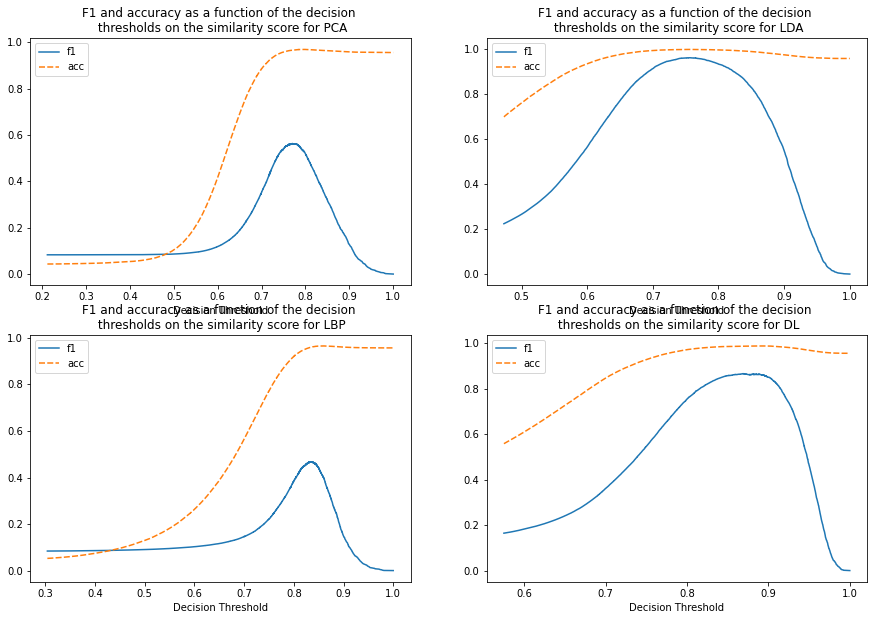

In [72]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_pca, "PCA", axes[0][0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lda, "LDA", axes[0][1])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lbp, "LBP", axes[1][0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl, "DL", axes[1][1])

<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

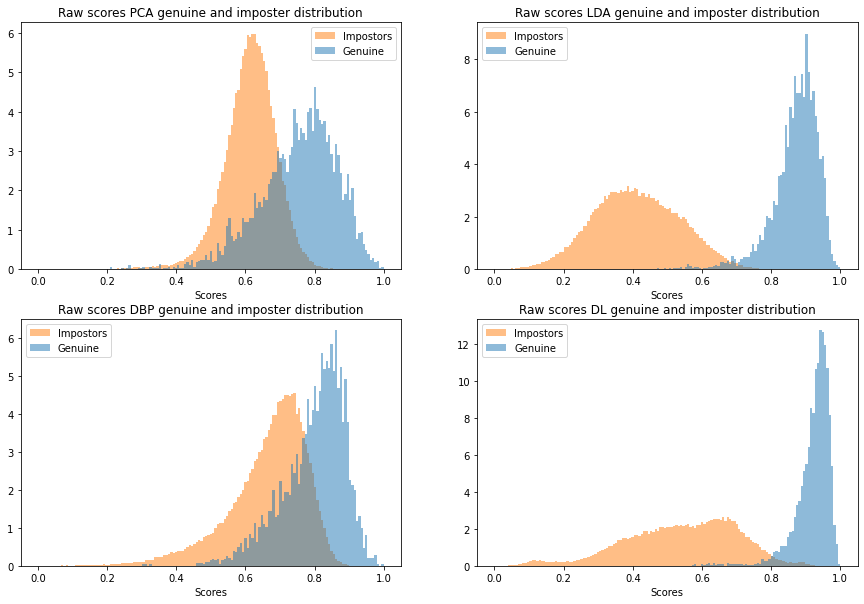

In [73]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
# left index
metrics.plot_score_distribution(axes[0][0], imposter_df_pca, genuine_df_pca, "PCA genuine and imposter distribution")
metrics.plot_score_distribution(axes[0][1], imposter_df_lda, genuine_df_lda, "LDA genuine and imposter distribution")
metrics.plot_score_distribution(axes[1][0], imposter_df_lbp, genuine_df_lbp, "DBP genuine and imposter distribution")
metrics.plot_score_distribution(axes[1][1], imposter_df_dl, genuine_df_dl, "DL genuine and imposter distribution")

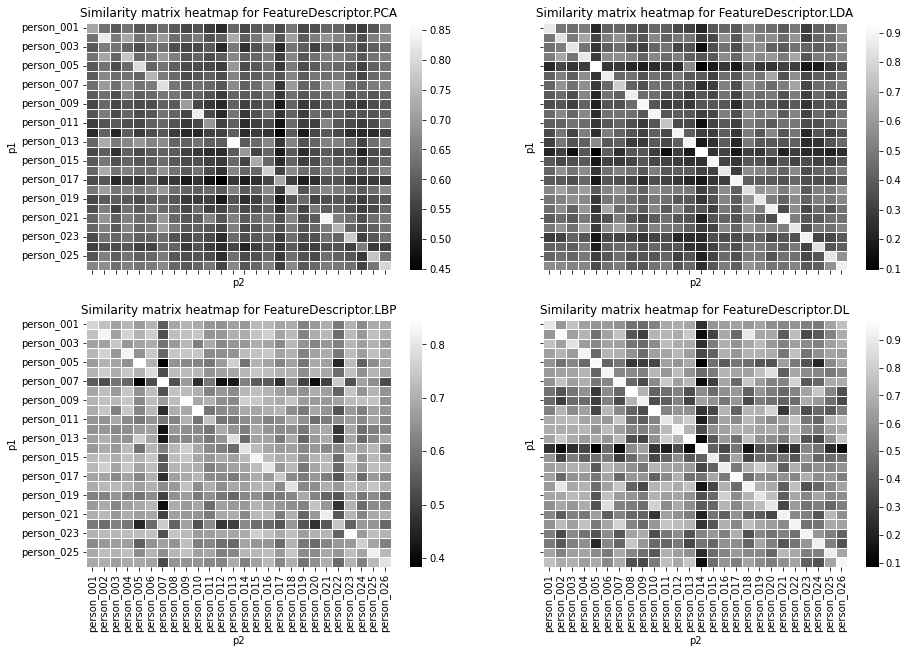

In [74]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_pca, axes[0][0], FeatureDescriptor.PCA)
metrics.plot_sim_matrix(face_mat_lda, axes[0][1], FeatureDescriptor.LDA)
metrics.plot_sim_matrix(face_mat_lbp, axes[1][0], FeatureDescriptor.LBP)
metrics.plot_sim_matrix(face_mat_dl, axes[1][1], FeatureDescriptor.DL)

<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

In [75]:
fpr_roc_pca, fnr_roc_pca, tpr_roc_pca, threshold_roc_pca = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_pca, y_true_pca)
fpr_roc_lda, fnr_roc_lda, tpr_roc_lda, threshold_roc_lda = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lda, y_true_lda)
fpr_roc_lbp, fnr_roc_lbp, tpr_roc_lbp, threshold_roc_lbp = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lbp, y_true_lbp)
fpr_roc_dl, fnr_roc_dl, tpr_roc_dl, threshold_roc_dl = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_dl, y_true_dl)

2022-05-20 12:33:12,451 - Computing roc curve
2022-05-20 12:33:12,477 - End roc curve computation
2022-05-20 12:33:12,478 - Computing roc curve
2022-05-20 12:33:12,503 - End roc curve computation
2022-05-20 12:33:12,504 - Computing roc curve
2022-05-20 12:33:12,528 - End roc curve computation
2022-05-20 12:33:12,529 - Computing roc curve
2022-05-20 12:33:12,554 - End roc curve computation


### ROC score

In [76]:
from sklearn.metrics import roc_auc_score
roc_au_pca = roc_auc_score(y_true=score_pca, y_score=y_true_pca)
roc_au_lda = roc_auc_score(y_true=score_lda, y_score=y_true_lda)
roc_au_lbp = roc_auc_score(y_true=score_lbp, y_score=y_true_lbp)
roc_au_dl = roc_auc_score(y_true=score_dl, y_score=y_true_dl)
print('ROC score for PCA : ', roc_au_pca)
print('ROC score for LDA : ', roc_au_lda)
print('ROC score for LBP : ', roc_au_lbp)
print('ROC score for DL : ', roc_au_dl)

ROC score for PCA :  0.8538259509352171
ROC score for LDA :  0.9984974967708357
ROC score for LBP :  0.84012165521448
ROC score for DL :  0.9946904052353734


### EER thresholds

In [77]:
eer_threshold_roc_pca = threshold_roc_pca[np.nanargmin(np.absolute((fnr_roc_pca - fpr_roc_pca)))]
eer_threshold_roc_lda = threshold_roc_lda[np.nanargmin(np.absolute((fnr_roc_lda - fpr_roc_lda)))]
eer_threshold_roc_lbp = threshold_roc_lbp[np.nanargmin(np.absolute((fnr_roc_lbp - fpr_roc_lbp)))]
eer_threshold_roc_dl = threshold_roc_dl[np.nanargmin(np.absolute((fnr_roc_dl - fpr_roc_dl)))]
print('EER threshold for PCA : ', eer_threshold_roc_pca)
print('EER threshold for LDA : ', eer_threshold_roc_lda)
print('EER threshold for LBP : ', eer_threshold_roc_lbp)
print('EER threshold for DL : ', eer_threshold_roc_dl)

EER threshold for PCA :  0.6705331455354107
EER threshold for LDA :  0.6702372683719546
EER threshold for LBP :  0.745927988712306
EER threshold for DL :  0.8038245418032111


In [78]:
df_decision_threshold_fpr_fnr_pca = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_pca, tpr_roc_pca], index_values=threshold_roc_pca)
df_decision_threshold_fpr_fnr_lda = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_lda, tpr_roc_lda], index_values=threshold_roc_lda)
df_decision_threshold_fpr_fnr_lbp = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_lbp, tpr_roc_lbp], index_values=threshold_roc_lbp)
df_decision_threshold_fpr_fnr_dl = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_dl, tpr_roc_dl], index_values=threshold_roc_dl)

In [79]:
result_roc_pca = df_decision_threshold_fpr_fnr_pca.loc[eer_threshold_roc_pca]
result_roc_lda = df_decision_threshold_fpr_fnr_lda.loc[eer_threshold_roc_lda]
result_roc_lbp = df_decision_threshold_fpr_fnr_lbp.loc[eer_threshold_roc_lbp]
result_roc_dl = df_decision_threshold_fpr_fnr_dl.loc[eer_threshold_roc_dl]

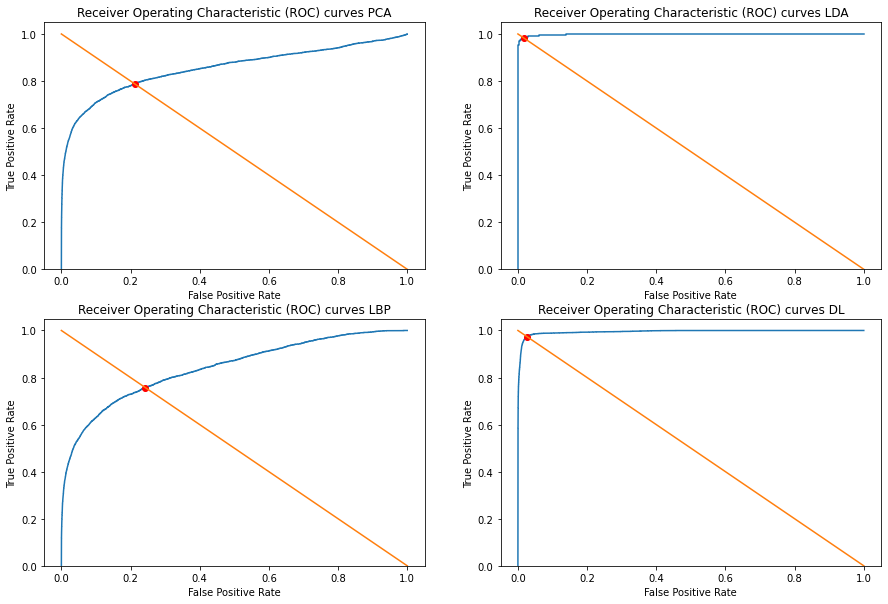

In [80]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_roc_pca, tpr_roc_pca, axes[0][0], result_roc_pca, "PCA")
metrics.plot_eer_roc(fpr_roc_lda, tpr_roc_lda, axes[0][1], result_roc_lda, "LDA")
metrics.plot_eer_roc(fpr_roc_lbp, tpr_roc_lbp, axes[1][0], result_roc_lbp, "LBP")
metrics.plot_eer_roc(fpr_roc_dl, tpr_roc_dl, axes[1][1], result_roc_dl, "DL")

In [81]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_pca["sum"] = df_decision_threshold_fpr_fnr_pca.sum(axis=1)
df_decision_threshold_fpr_fnr_lda["sum"] = df_decision_threshold_fpr_fnr_lda.sum(axis=1)
df_decision_threshold_fpr_fnr_lbp["sum"] = df_decision_threshold_fpr_fnr_lbp.sum(axis=1)
df_decision_threshold_fpr_fnr_dl["sum"] = df_decision_threshold_fpr_fnr_dl.sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for PCA', df_decision_threshold_fpr_fnr_pca["sum"].idxmin())
print('threshold for LDA', df_decision_threshold_fpr_fnr_lda["sum"].idxmin())
print('threshold for LBP', df_decision_threshold_fpr_fnr_lbp["sum"].idxmin())
print('threshold for DL', df_decision_threshold_fpr_fnr_dl["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for PCA 2.0
threshold for LDA 2.0
threshold for LBP 2.0
threshold for DL 2.0


### Precision recall curve

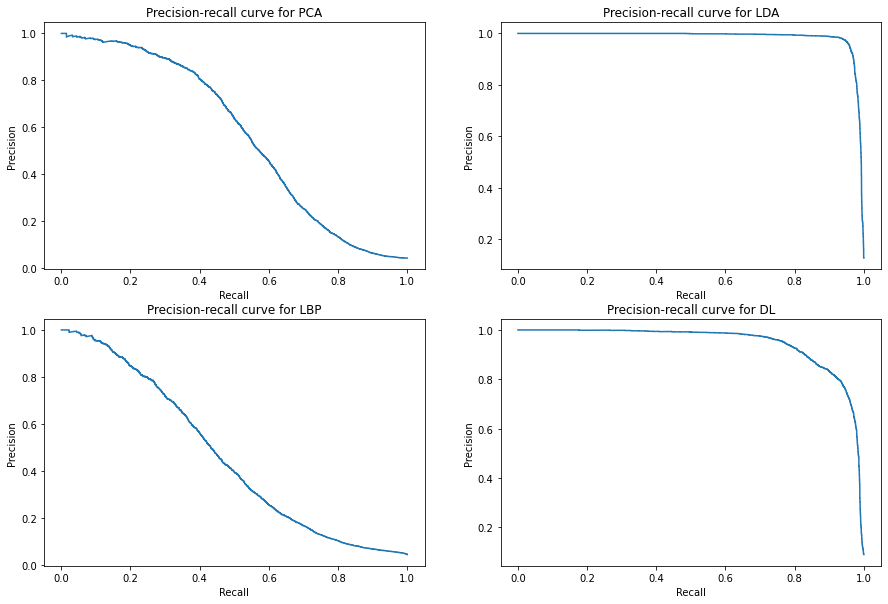

In [82]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_recall_precision(recall_pca, precision_pca, axes[0][0], title_add="PCA")
metrics.plot_recall_precision(recall_lda, precision_lda, axes[0][1], title_add="LDA")
metrics.plot_recall_precision(recall_lbp, precision_lbp, axes[1][0], title_add="LBP")
metrics.plot_recall_precision(recall_dl, precision_dl, axes[1][1], title_add="DL")

#### Average precision score

In [83]:
"""Calculate the average precision scores"""
average_prec_score_pca = average_precision_score(y_true=score_pca, y_score=y_true_pca)
average_prec_score_lda = average_precision_score(y_true=score_lda, y_score=y_true_lda)
average_prec_score_lbp = average_precision_score(y_true=score_lbp, y_score=y_true_lbp)
average_prec_score_dl = average_precision_score(y_true=score_dl, y_score=y_true_dl)
print('Average precision score for PCA', average_prec_score_pca)
print('Average precision score for LDA', average_prec_score_lda)
print('Average precision score for LBP', average_prec_score_lbp)
print('Average precision score for DL', average_prec_score_dl)

Average precision score for PCA 0.5690883592673932
Average precision score for LDA 0.9853387732625173
Average precision score for LBP 0.46043081437238187
Average precision score for DL 0.9459504108789053


### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario. 
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

In [84]:
face_mat_lda

p2,person_001,person_002,person_003,person_004,person_005,person_006,person_007,person_008,person_009,person_010,...,person_017,person_018,person_019,person_020,person_021,person_022,person_023,person_024,person_025,person_026
p1,,,,,,,,,,,,,,,,,,,,,
person_001,0.858190,0.482878,0.462904,0.502984,0.228204,0.416450,0.430342,0.391809,0.351576,0.441144,...,0.388686,0.536693,0.485987,0.457285,0.395929,0.489557,0.291416,0.415870,0.425603,0.554358
person_002,0.482878,0.832485,0.498495,0.638965,0.323602,0.512578,0.575778,0.446568,0.376465,0.540354,...,0.387884,0.622386,0.519135,0.558652,0.445136,0.578847,0.312647,0.426370,0.459819,0.545245
person_003,0.462904,0.498495,0.849990,0.477264,0.269576,0.406402,0.461194,0.353388,0.305030,0.430169,...,0.352078,0.532890,0.559944,0.417630,0.389875,0.469492,0.418742,0.407790,0.426794,0.526387
person_004,0.502984,0.638965,0.477264,0.856741,0.291945,0.558653,0.565554,0.535500,0.421481,0.536877,...,0.431008,0.612736,0.544589,0.590406,0.496989,0.639571,0.379460,0.500073,0.490456,0.534651
person_005,0.228204,0.323602,0.269576,0.291945,0.932425,0.268596,0.286351,0.227541,0.200545,0.244506,...,0.172771,0.395382,0.282026,0.268054,0.304034,0.291425,0.165636,0.188706,0.294891,0.346495
person_006,0.416450,0.512578,0.406402,0.558653,0.268596,0.873767,0.438509,0.465734,0.370690,0.464972,...,0.377127,0.534571,0.483640,0.641632,0.366700,0.560025,0.335905,0.410854,0.381203,0.467160
person_007,0.430342,0.575778,0.461194,0.565554,0.286351,0.438509,0.770055,0.412981,0.361837,0.469330,...,0.355401,0.579290,0.505511,0.447072,0.506524,0.631788,0.324352,0.446413,0.460734,0.503919
person_008,0.391809,0.446568,0.353388,0.535500,0.227541,0.465734,0.412981,0.871426,0.450515,0.458460,...,0.323826,0.494625,0.451484,0.494228,0.366625,0.501491,0.301741,0.438013,0.365759,0.399981
person_009,0.351576,0.376465,0.305030,0.421481,0.200545,0.370690,0.361837,0.450515,0.907362,0.379825,...,0.242411,0.422278,0.404066,0.396395,0.321439,0.387960,0.265576,0.362617,0.373566,0.378902


In [85]:
ranked_pca = metrics.compute_cmc(face_mat_pca)
ranked_lda= metrics.compute_cmc(face_mat_lda)
ranked_lbp = metrics.compute_cmc(face_mat_lbp)
ranked_dl = metrics.compute_cmc(face_mat_dl)
ranked_lda

[0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0    1.0
1    1.0
dtype: float64

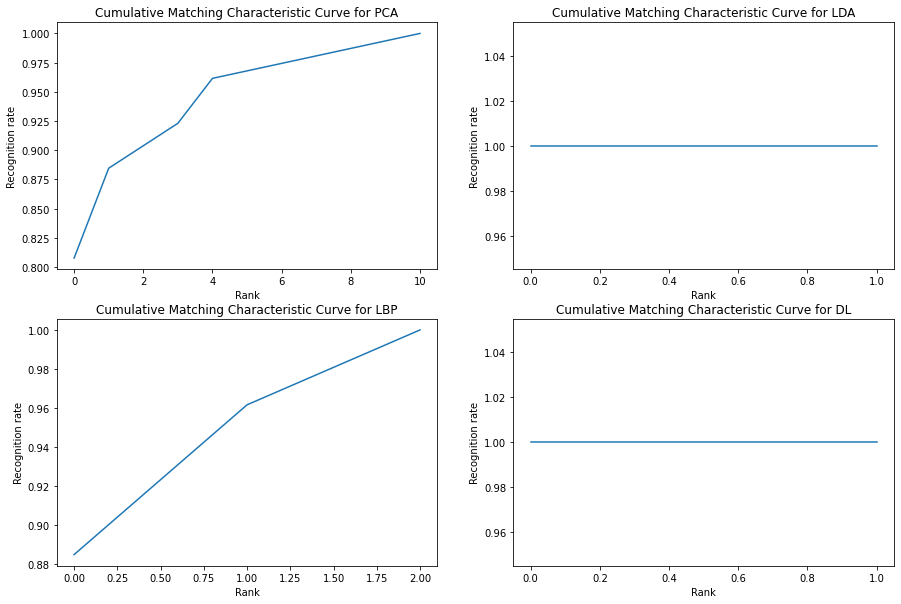

In [49]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_cmc(ranked_pca, axes[0][0], "PCA")
metrics.plot_cmc(ranked_lda, axes[0][1], "LDA")
metrics.plot_cmc(ranked_lbp, axes[1][0], "LBP")
metrics.plot_cmc(ranked_dl, axes[1][1], "DL")

## VI. Tasks
All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics in Questions 2-5, and report on the performance. Please make it clear where in your report the comparison is made for each question. 

### 2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.)
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section IV. Distance-based and classification-based scoring) (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.) 
6. Implement a different deep learning model* (2pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

#### 2.1 Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)

##### AT&T face database evaluation

In [52]:
att_faces = fetch_olivetti_faces(data_home='.')

# Convert grayscale to RGB dimension
att_faces.images = np.expand_dims(att_faces.images, axis=-1)
print("AT&T keys: ", att_faces.keys())
print("LFW image shape", att_faces.images.shape)
labels_att = []
for target in att_faces.target:
    pre = "" if target > 8 else "0"
    labels_att.append("person_0" + pre + str(target+1))
labels_att

AT&T keys:  dict_keys(['data', 'images', 'target', 'DESCR'])
LFW image shape (400, 64, 64, 1)


['person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_001',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_002',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_003',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_004',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_005',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_006',
 'person_007',
 'person_007',
 'person_007',
 'person_007',
 'person_007',
 'person_007',
 'person_0

In [53]:
att_imshape, n_samples_att, n_classes_att, n_features_att = utils.get_image_db_statistic(att_faces)

Total dataset size:
n_samples: 400
n_classes: 40
n_features: 4096
imshape : (64, 64, 1)


visualize some faces

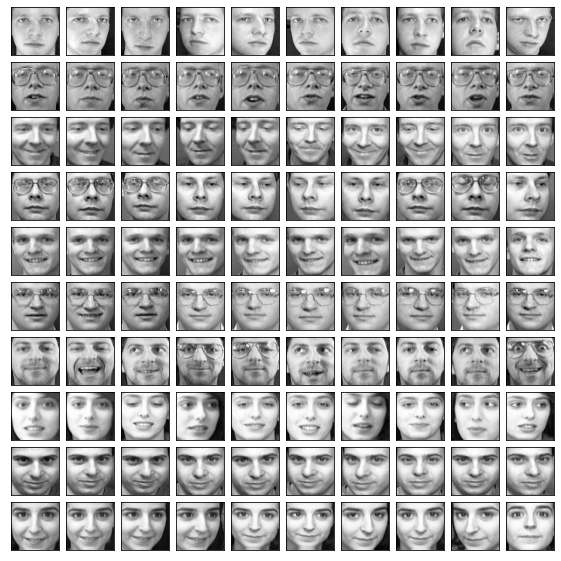

In [54]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, att_faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [55]:
facial_descriptor_att = FacialDescriptor(num_components, att_faces, n_samples_att, n_features_att, n_classes_att, att_imshape)

##### Get similarity scores
###### PCA

In [56]:
embedded_PCA_att, dist_metric_PCA_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.PCA)
df_scores_PCA_att, similarity_mat_pca_att = utils.compute_similarity_matrix(embedded_PCA_att, dist_metric_PCA_att, labels_att)
df_scores_PCA_att

False
num_components 25


100%|██████████| 400/400 [00:01<00:00, 290.49it/s]


,p1,p2,genuine,score,scores_norm
0,person_001,person_001,1,7.150987,0.465801
1,person_001,person_001,1,3.255030,0.778757
2,person_001,person_001,1,6.293606,0.534673
3,person_001,person_001,1,5.671691,0.584631
4,person_001,person_001,1,6.989410,0.478780
...,...,...,...,...,...
159595,person_040,person_040,1,6.369842,0.528549
159596,person_040,person_040,1,6.441494,0.522794
159597,person_040,person_040,1,3.507516,0.758475
159598,person_040,person_040,1,5.633273,0.587717


In [57]:
face_mat_pca_att = df_scores_PCA_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_pca_att

p2,person_001,person_002,person_003,person_004,person_005,person_006,person_007,person_008,person_009,person_010,...,person_031,person_032,person_033,person_034,person_035,person_036,person_037,person_038,person_039,person_040
p1,,,,,,,,,,,,,,,,,,,,,
person_001,0.541045,0.500340,0.475421,0.475335,0.497257,0.523806,0.407841,0.426381,0.475807,0.426859,...,0.458443,0.459567,0.412412,0.396200,0.387272,0.371964,0.414049,0.481695,0.487842,0.483485
person_002,0.500340,0.705512,0.457630,0.570925,0.503208,0.534196,0.407990,0.418669,0.472663,0.405836,...,0.516003,0.506721,0.385452,0.460631,0.371631,0.391741,0.416932,0.517968,0.506270,0.505182
person_003,0.475421,0.457630,0.651371,0.553316,0.567155,0.541656,0.481772,0.448241,0.505803,0.501388,...,0.495173,0.514626,0.440641,0.472474,0.484889,0.395956,0.478959,0.525514,0.541605,0.585511
person_004,0.475335,0.570925,0.553316,0.653531,0.542513,0.549533,0.457556,0.435289,0.542768,0.483712,...,0.486378,0.514464,0.461006,0.453270,0.407619,0.428371,0.463539,0.545217,0.525047,0.567671
person_005,0.497257,0.503208,0.567155,0.542513,0.713665,0.618322,0.453323,0.449641,0.545254,0.488764,...,0.551803,0.522684,0.482499,0.456614,0.491652,0.474121,0.450336,0.552785,0.550961,0.607505
person_006,0.523806,0.534196,0.541656,0.549533,0.618322,0.763641,0.481656,0.444543,0.547277,0.457904,...,0.571346,0.484028,0.467573,0.435768,0.462281,0.427773,0.417345,0.551924,0.463708,0.558804
person_007,0.407841,0.407990,0.481772,0.457556,0.453323,0.481656,0.584089,0.344597,0.475142,0.389176,...,0.427109,0.476973,0.399320,0.375343,0.376171,0.394216,0.390537,0.467774,0.426842,0.457179
person_008,0.426381,0.418669,0.448241,0.435289,0.449641,0.444543,0.344597,0.521197,0.406052,0.450089,...,0.383969,0.410134,0.364633,0.326053,0.386781,0.300987,0.325692,0.452822,0.452057,0.438033
person_009,0.475807,0.472663,0.505803,0.542768,0.545254,0.547277,0.475142,0.406052,0.727492,0.512868,...,0.531839,0.466484,0.470397,0.440676,0.436311,0.402776,0.427406,0.544852,0.554502,0.561605


In [58]:
genuine_df_pca_att = df_scores_PCA_att['scores_norm'][df_scores_PCA_att['genuine'] == 1]
imposter_df_pca_att = df_scores_PCA_att['scores_norm'][df_scores_PCA_att['genuine'] == 0]

###### LDA

In [59]:
embedded_LDA_att, dist_metric_LDA_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.LDA)
df_scores_LDA_att, similarity_mat_lda_att = utils.compute_similarity_matrix(embedded_LDA_att, dist_metric_LDA_att, labels_att)

face_mat_lda_att = df_scores_LDA_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_lda_att = df_scores_LDA_att['scores_norm'][df_scores_LDA_att['genuine'] == 1]
imposter_df_lda_att = df_scores_LDA_att['scores_norm'][df_scores_LDA_att['genuine'] == 0]

False


100%|██████████| 400/400 [00:01<00:00, 368.66it/s]


###### LBP

In [60]:
embedded_LBP_att, dist_metric_LBP_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.LBP)
df_scores_LBP_att, similarity_mat_lbp_att = utils.compute_similarity_matrix(embedded_LBP_att, utils.chi2, labels_att)

face_mat_lbp_att = df_scores_LBP_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_lbp_att = df_scores_LBP_att['scores_norm'][df_scores_LBP_att['genuine'] == 1]
imposter_df_lbp_att = df_scores_LBP_att['scores_norm'][df_scores_LBP_att['genuine'] == 0]

ic| DESC: <FeatureDescriptor.LBP: 'LBP'>


False


100%|██████████| 400/400 [00:01<00:00, 317.96it/s]


###### DL

In [61]:
embedded_DL_att, dist_metric_DL_att = facial_descriptor_att.extract_face_representation(DESC=FeatureDescriptor.DL, holdout_split=holdout_split)
df_scores_DL_att, similarity_mat_dl_att = utils.compute_similarity_matrix(embedded_DL_att, dist_metric_DL, labels_att)

face_mat_dl_att = df_scores_DL_att.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_dl_att = df_scores_DL_att['scores_norm'][df_scores_DL_att['genuine'] == 1]
imposter_df_dl_att = df_scores_DL_att['scores_norm'][df_scores_DL_att['genuine'] == 0]

True
FeatureDescriptor.DL
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          1680832     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           [

100%|██████████| 400/400 [00:01<00:00, 358.42it/s]


##### evaluate

Compute F1 and accuracy scores for variable (and optimal) thresholds

In [62]:
score_pca_att, y_true_pca_att = df_scores_PCA_att['genuine'], df_scores_PCA_att['scores_norm']
score_lda_att, y_true_lda_att = df_scores_LDA_att['genuine'], df_scores_LDA_att['scores_norm']
score_lbp_att, y_true_lbp_att = df_scores_LBP_att['genuine'], df_scores_LBP_att['scores_norm']
score_dl_att, y_true_dl_att = df_scores_DL_att['genuine'], df_scores_DL_att['scores_norm']

df_classification_metrics_pca_att, precision_pca_att, recall_pca_att = metrics.get_f1_and_acc_dataframe(genuine_df_pca_att, imposter_df_pca_att, score_pca_att, y_true_pca_att)
df_classification_metrics_lda_att, precision_lda_att, recall_lda_att = metrics.get_f1_and_acc_dataframe(genuine_df_lda_att, imposter_df_lda_att, score_lda_att, y_true_lda_att)
df_classification_metrics_lbp_att, precision_lbp_att, recall_lbp_att = metrics.get_f1_and_acc_dataframe(genuine_df_lbp_att, imposter_df_lbp_att, score_lbp_att, y_true_lbp_att)
df_classification_metrics_dl_att, precision_dl_att, recall_dl_att = metrics.get_f1_and_acc_dataframe(genuine_df_dl_att, imposter_df_dl_att, score_dl_att, y_true_dl_att)

2022-05-17 12:46:48,896 - Computing precision recall
2022-05-17 12:46:48,915 - End precision recall computation
2022-05-17 12:46:48,916 - Computing accuracy
2022-05-17 12:46:55,429 - Generate dataframe
2022-05-17 12:46:55,442 - dataframe generated
2022-05-17 12:46:55,443 - Computing precision recall
2022-05-17 12:46:55,463 - End precision recall computation
2022-05-17 12:46:55,464 - Computing accuracy
2022-05-17 12:46:56,190 - Generate dataframe
2022-05-17 12:46:56,194 - dataframe generated
2022-05-17 12:46:56,195 - Computing precision recall
2022-05-17 12:46:56,216 - End precision recall computation
2022-05-17 12:46:56,217 - Computing accuracy
2022-05-17 12:47:02,369 - Generate dataframe
2022-05-17 12:47:02,379 - dataframe generated
2022-05-17 12:47:02,381 - Computing precision recall
2022-05-17 12:47:02,401 - End precision recall computation
2022-05-17 12:47:02,401 - Computing accuracy
2022-05-17 12:47:04,285 - Generate dataframe
2022-05-17 12:47:04,290 - dataframe generated


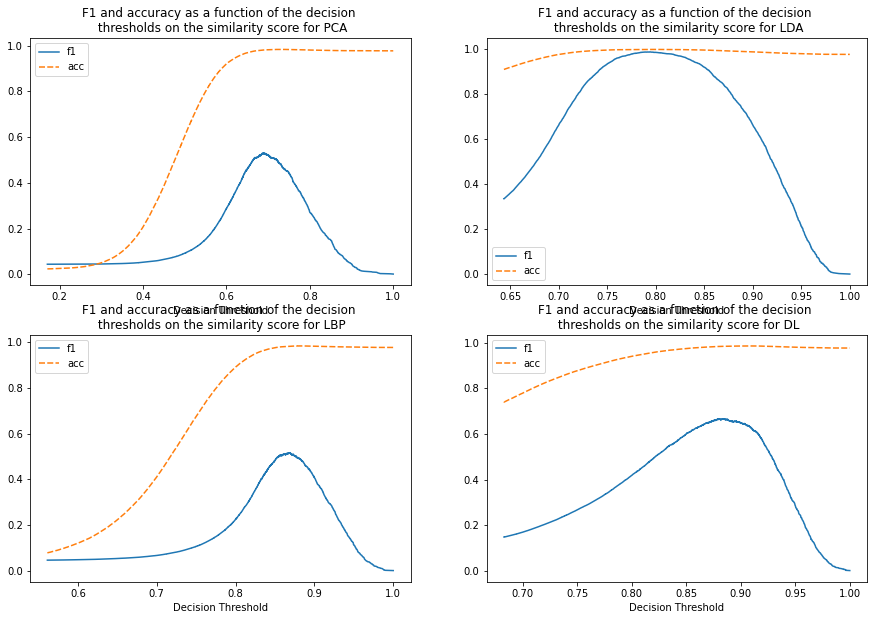

In [63]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_pca_att, "PCA", axes[0][0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lda_att, "LDA", axes[0][1])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lbp_att, "LBP", axes[1][0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl_att, "DL", axes[1][1])

Plot genuine and impostor scores
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

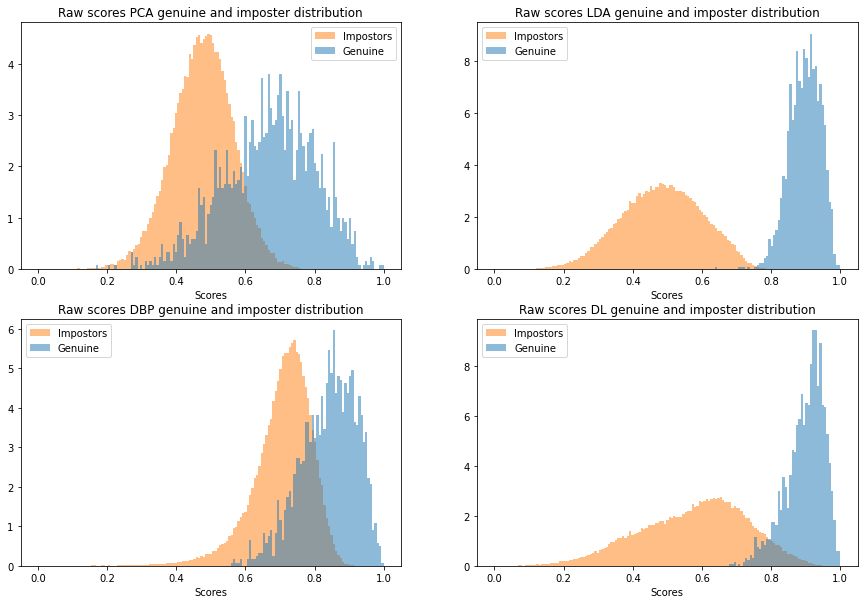

In [64]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
# left index
metrics.plot_score_distribution(axes[0][0], imposter_df_pca_att, genuine_df_pca_att, "PCA genuine and imposter distribution")
metrics.plot_score_distribution(axes[0][1], imposter_df_lda_att, genuine_df_lda_att, "LDA genuine and imposter distribution")
metrics.plot_score_distribution(axes[1][0], imposter_df_lbp_att, genuine_df_lbp_att, "DBP genuine and imposter distribution")
metrics.plot_score_distribution(axes[1][1], imposter_df_dl_att, genuine_df_dl_att, "DL genuine and imposter distribution")

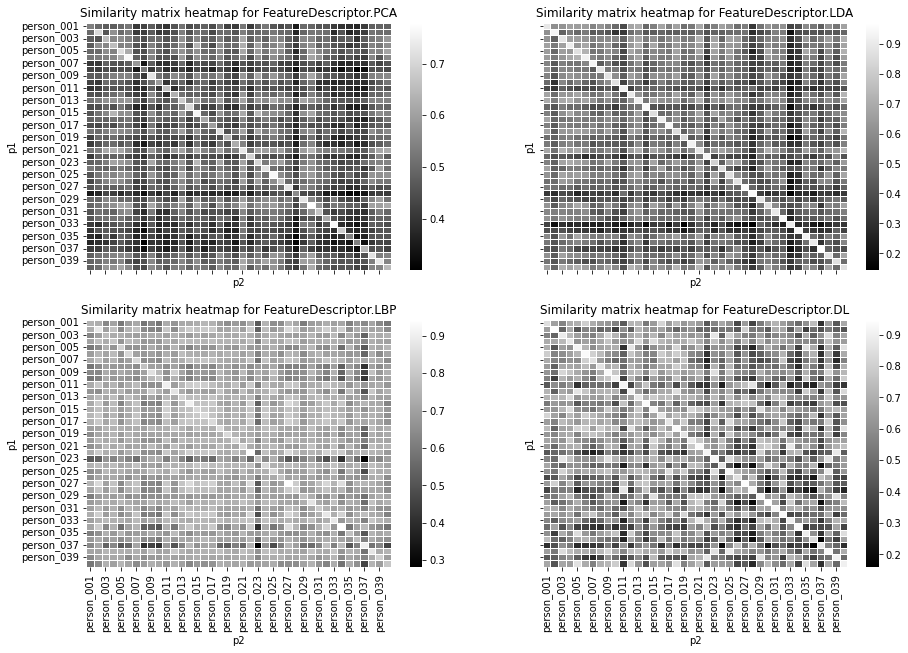

In [65]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_pca_att, axes[0][0], FeatureDescriptor.PCA)
metrics.plot_sim_matrix(face_mat_lda_att, axes[0][1], FeatureDescriptor.LDA)
metrics.plot_sim_matrix(face_mat_lbp_att, axes[1][0], FeatureDescriptor.LBP)
metrics.plot_sim_matrix(face_mat_dl_att, axes[1][1], FeatureDescriptor.DL)

Perform a full-on verification assessment based on the scores obtained. Interpret the results.

In [66]:
fpr_roc_pca_att, fnr_roc_pca_att, tpr_roc_pca_att, threshold_roc_pca_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_pca_att, y_true_pca_att)
fpr_roc_lda_att, fnr_roc_lda_att, tpr_roc_lda_att, threshold_roc_lda_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lda_att, y_true_lda_att)
fpr_roc_lbp_att, fnr_roc_lbp_att, tpr_roc_lbp_att, threshold_roc_lbp_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lbp_att, y_true_lbp_att)
fpr_roc_dl_att, fnr_roc_dl_att, tpr_roc_dl_att, threshold_roc_dl_att = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_dl_att, y_true_dl_att)

2022-05-17 12:47:17,622 - Computing roc curve
2022-05-17 12:47:17,642 - End roc curve computation
2022-05-17 12:47:17,643 - Computing roc curve
2022-05-17 12:47:17,662 - End roc curve computation
2022-05-17 12:47:17,662 - Computing roc curve
2022-05-17 12:47:17,683 - End roc curve computation
2022-05-17 12:47:17,683 - Computing roc curve
2022-05-17 12:47:17,702 - End roc curve computation


In [67]:
roc_au_pca_att = roc_auc_score(y_true=score_pca_att, y_score=y_true_pca_att)
roc_au_lda_att = roc_auc_score(y_true=score_lda_att, y_score=y_true_lda_att)
roc_au_lbp_att = roc_auc_score(y_true=score_lbp_att, y_score=y_true_lbp_att)
roc_au_dl_att = roc_auc_score(y_true=score_dl_att, y_score=y_true_dl_att)
print('ROC score for PCA : ', roc_au_pca_att)
print('ROC score for LDA : ', roc_au_lda_att)
print('ROC score for LBP : ', roc_au_lbp_att)
print('ROC score for DL : ', roc_au_dl_att)

ROC score for PCA :  0.8815995334757835
ROC score for LDA :  0.9999104415954416
ROC score for LBP :  0.878029594017094
ROC score for DL :  0.9864937927350427


In [68]:
eer_threshold_roc_pca_att = threshold_roc_pca_att[np.nanargmin(np.absolute((fnr_roc_pca_att - fpr_roc_pca_att)))]
eer_threshold_roc_lda_att = threshold_roc_lda_att[np.nanargmin(np.absolute((fnr_roc_lda_att - fpr_roc_lda_att)))]
eer_threshold_roc_lbp_att = threshold_roc_lbp_att[np.nanargmin(np.absolute((fnr_roc_lbp_att - fpr_roc_lbp_att)))]
eer_threshold_roc_dl_att = threshold_roc_dl_att[np.nanargmin(np.absolute((fnr_roc_dl_att - fpr_roc_dl_att)))]
print('EER threshold for PCA : ', eer_threshold_roc_pca_att)
print('EER threshold for LDA : ', eer_threshold_roc_lda_att)
print('EER threshold for LBP : ', eer_threshold_roc_lbp_att)
print('EER threshold for DL : ', eer_threshold_roc_dl_att)

EER threshold for PCA :  0.5502601633944781
EER threshold for LDA :  0.758253999198583
EER threshold for LBP :  0.7737729167313396
EER threshold for DL :  0.7996802979098809


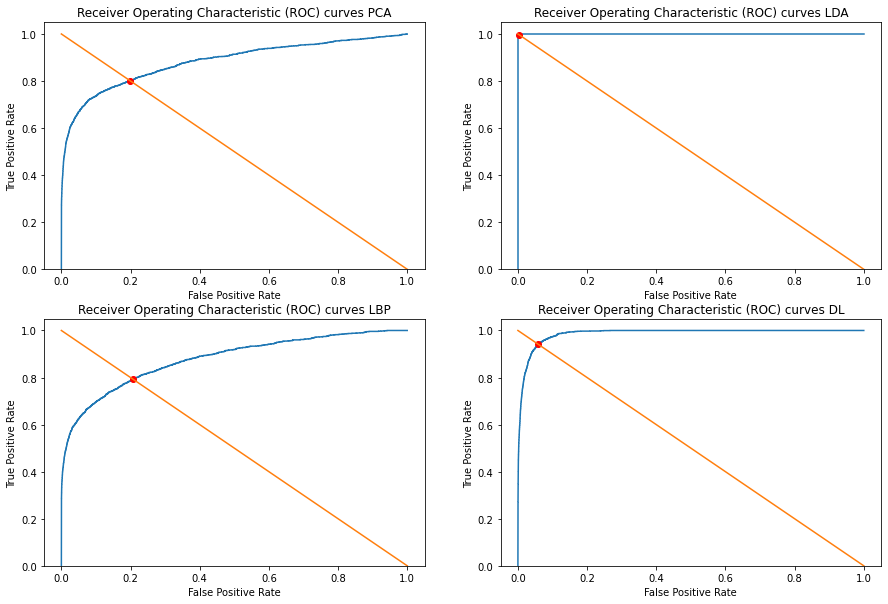

In [69]:
df_decision_threshold_fpr_fnr_pca_att = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_pca_att, tpr_roc_pca_att], index_values=threshold_roc_pca_att)
df_decision_threshold_fpr_fnr_lda_att = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_lda_att, tpr_roc_lda_att], index_values=threshold_roc_lda_att)
df_decision_threshold_fpr_fnr_lbp_att = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_lbp_att, tpr_roc_lbp_att], index_values=threshold_roc_lbp_att)
df_decision_threshold_fpr_fnr_dl_att = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_dl_att, tpr_roc_dl_att], index_values=threshold_roc_dl_att)

result_roc_pca_att = df_decision_threshold_fpr_fnr_pca_att.loc[eer_threshold_roc_pca_att]
result_roc_lda_att = df_decision_threshold_fpr_fnr_lda_att.loc[eer_threshold_roc_lda_att]
result_roc_lbp_att = df_decision_threshold_fpr_fnr_lbp_att.loc[eer_threshold_roc_lbp_att]
result_roc_dl_att = df_decision_threshold_fpr_fnr_dl_att.loc[eer_threshold_roc_dl_att]

figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_roc_pca_att, tpr_roc_pca_att, axes[0][0], result_roc_pca_att, "PCA")
metrics.plot_eer_roc(fpr_roc_lda_att, tpr_roc_lda_att, axes[0][1], result_roc_lda_att, "LDA")
metrics.plot_eer_roc(fpr_roc_lbp_att, tpr_roc_lbp_att, axes[1][0], result_roc_lbp_att, "LBP")
metrics.plot_eer_roc(fpr_roc_dl_att, tpr_roc_dl_att, axes[1][1], result_roc_dl_att, "DL")

In [70]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_pca_att["sum"] = df_decision_threshold_fpr_fnr_pca_att.sum(axis=1)
df_decision_threshold_fpr_fnr_lda_att["sum"] = df_decision_threshold_fpr_fnr_lda_att.sum(axis=1)
df_decision_threshold_fpr_fnr_lbp_att["sum"] = df_decision_threshold_fpr_fnr_lbp_att.sum(axis=1)
df_decision_threshold_fpr_fnr_dl_att["sum"] = df_decision_threshold_fpr_fnr_dl_att.sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for PCA', df_decision_threshold_fpr_fnr_pca_att["sum"].idxmin())
print('threshold for LDA', df_decision_threshold_fpr_fnr_lda_att["sum"].idxmin())
print('threshold for LBP', df_decision_threshold_fpr_fnr_lbp_att["sum"].idxmin())
print('threshold for DL', df_decision_threshold_fpr_fnr_dl_att["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for PCA 2.0
threshold for LDA 2.0
threshold for LBP 2.0
threshold for DL 2.0


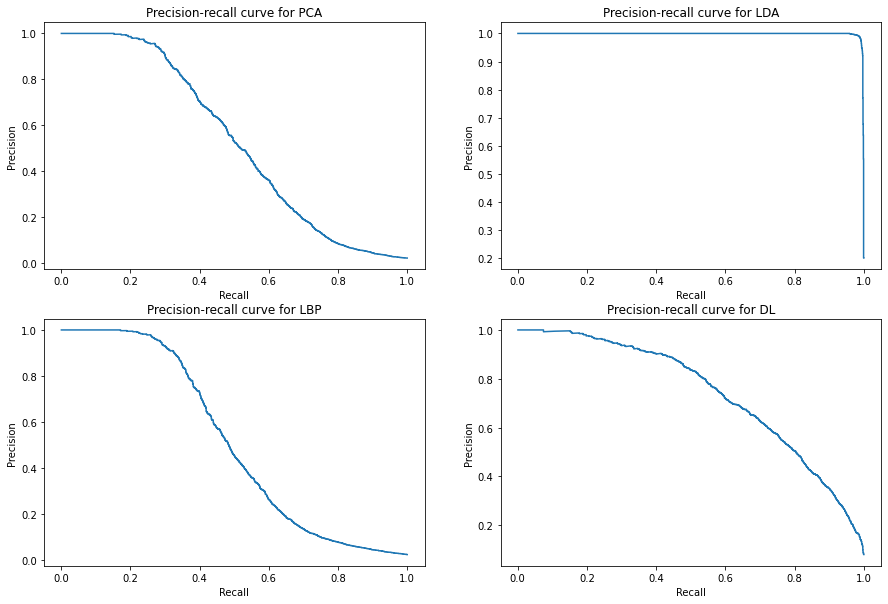

In [71]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_recall_precision(recall_pca_att, precision_pca_att, axes[0][0], title_add="PCA")
metrics.plot_recall_precision(recall_lda_att, precision_lda_att, axes[0][1], title_add="LDA")
metrics.plot_recall_precision(recall_lbp_att, precision_lbp_att, axes[1][0], title_add="LBP")
metrics.plot_recall_precision(recall_dl_att, precision_dl_att, axes[1][1], title_add="DL")

In [72]:
"""Calculate the average precision scores"""
average_prec_score_pca_att = average_precision_score(y_true=score_pca_att, y_score=y_true_pca_att)
average_prec_score_lda_att = average_precision_score(y_true=score_lda_att, y_score=y_true_lda_att)
average_prec_score_lbp_att = average_precision_score(y_true=score_lbp_att, y_score=y_true_lbp_att)
average_prec_score_dl_att = average_precision_score(y_true=score_dl_att, y_score=y_true_dl_att)
print('Average precision score for PCA', average_prec_score_pca_att)
print('Average precision score for LDA', average_prec_score_lda_att)
print('Average precision score for LBP', average_prec_score_lbp_att)
print('Average precision score for DL', average_prec_score_dl_att)

Average precision score for PCA 0.5334606961184922
Average precision score for LDA 0.9983240407293815
Average precision score for LBP 0.5143816590454713
Average precision score for DL 0.7438126596307252


Validate the systems in an identification scenario.

In [73]:
ranked_pca_att = metrics.compute_cmc(face_mat_pca_att)
ranked_lda_att= metrics.compute_cmc(face_mat_lda_att)
ranked_lbp_att = metrics.compute_cmc(face_mat_lbp_att)
ranked_dl_att = metrics.compute_cmc(face_mat_dl_att)
ranked_pca_att

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0    1.0
1    1.0
dtype: float64

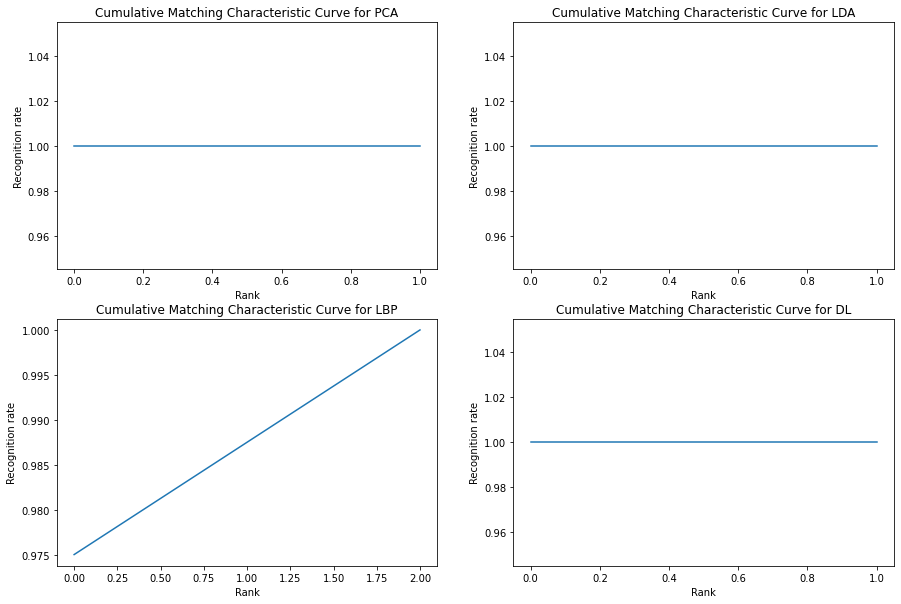

In [74]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_cmc(ranked_pca_att, axes[0][0], "PCA")
metrics.plot_cmc(ranked_lda_att, axes[0][1], "LDA")
metrics.plot_cmc(ranked_lbp_att, axes[1][0], "LBP")
metrics.plot_cmc(ranked_dl_att, axes[1][1], "DL")

##### Labeled faces in the Wild (lfw) database

In [2]:
lfw_faces = fetch_lfw_people(data_home='.', min_faces_per_person=20, slice_=(slice(70, 195), slice(70, 195)))
# Convert grayscale to RGB dimension
lfw_faces.images = np.expand_dims(lfw_faces.images, axis=-1)
print("LFW keys: ", lfw_faces.keys())
print("LFW image shape", lfw_faces.images.shape)
for key in lfw_faces.keys():
    print(lfw_faces[key][0:1])
labels_lfw = []
for target in lfw_faces.target:
    labels_lfw.append(lfw_faces.target_names[target])
labels_lfw

NameError: name 'fetch_lfw_people' is not defined

In [ ]:
lfw_imshape, n_samples_lfw, n_classes_lfw, n_features_lfw = utils.get_image_db_statistic(lfw_faces)

In [ ]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, lfw_faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
facial_descriptor_lfw = FacialDescriptor(num_components, lfw_faces, n_samples_lfw, n_features_lfw, n_classes_lfw, lfw_imshape)

##### Get similarity scores
###### PCA

In [ ]:
embedded_PCA_lfw, dist_metric_PCA_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.PCA)
df_scores_PCA_lfw, similarity_mat_pca_lfw = utils.compute_similarity_matrix(embedded_PCA_lfw, dist_metric_PCA_lfw, labels_lfw)
df_scores_PCA_lfw

In [ ]:
face_mat_pca_lfw = df_scores_PCA_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_pca_lfw = df_scores_PCA_lfw['scores_norm'][df_scores_PCA_lfw['genuine'] == 1]
imposter_df_pca_lfw = df_scores_PCA_lfw['scores_norm'][df_scores_PCA_lfw['genuine'] == 0]

In [ ]:
face_mat_pca_lfw

###### LDA

In [ ]:
embedded_LDA_lfw, dist_metric_LDA_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.LDA)
df_scores_LDA_lfw, similarity_mat_lda_lfw = utils.compute_similarity_matrix(embedded_LDA_lfw, dist_metric_LDA_lfw, labels_lfw)

face_mat_lda_lfw = df_scores_LDA_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_lda_lfw = df_scores_LDA_lfw['scores_norm'][df_scores_LDA_lfw['genuine'] == 1]
imposter_df_lda_lfw = df_scores_LDA_lfw['scores_norm'][df_scores_LDA_lfw['genuine'] == 0]

###### LBP

In [ ]:
embedded_LBP_lfw, dist_metric_LBP_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.LBP)
df_scores_LBP_lfw, similarity_mat_lbp_lfw = utils.compute_similarity_matrix(embedded_LBP_lfw, utils.chi2, labels_lfw)

face_mat_lbp_lfw = df_scores_LBP_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_lbp_lfw = df_scores_LBP_lfw['scores_norm'][df_scores_LBP_lfw['genuine'] == 1]
imposter_df_lbp_lfw = df_scores_LBP_lfw['scores_norm'][df_scores_LBP_lfw['genuine'] == 0]

###### DL

In [ ]:
embedded_DL_lfw, dist_metric_DL_lfw = facial_descriptor_lfw.extract_face_representation(DESC=FeatureDescriptor.DL, holdout_split=holdout_split)
df_scores_DL_lfw, similarity_mat_dl_lfw = utils.compute_similarity_matrix(embedded_DL_lfw, dist_metric_DL, labels_lfw)
#
face_mat_dl_lfw = df_scores_DL_lfw.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_dl_lfw = df_scores_DL_lfw['scores_norm'][df_scores_DL_lfw['genuine'] == 1]
imposter_df_dl_lfw = df_scores_DL_lfw['scores_norm'][df_scores_DL_lfw['genuine'] == 0]

##### evaluate

Compute F1 and accuracy scores for variable (and optimal) thresholds

In [ ]:
score_pca_lfw, y_true_pca_lfw = df_scores_PCA_lfw['genuine'], df_scores_PCA_lfw['scores_norm']
score_lda_lfw, y_true_lda_lfw = df_scores_LDA_lfw['genuine'], df_scores_LDA_lfw['scores_norm']
score_lbp_lfw, y_true_lbp_lfw = df_scores_LBP_lfw['genuine'], df_scores_LBP_lfw['scores_norm']

In [ ]:
score_dl_lfw, y_true_dl_lfw = df_scores_DL_lfw['genuine'], df_scores_DL_lfw['scores_norm']

In [ ]:
df_classification_metrics_pca_lfw, precision_pca_lfw, recall_pca_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_pca_lfw, imposter_df_pca_lfw, score_pca_lfw, y_true_pca_lfw)

In [ ]:
df_classification_metrics_lda_lfw, precision_lda_lfw, recall_lda_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_lda_lfw, imposter_df_lda_lfw, score_lda_lfw, y_true_lda_lfw)
df_classification_metrics_lbp_lfw, precision_lbp_lfw, recall_lbp_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_lbp_lfw, imposter_df_lbp_lfw, score_lbp_lfw, y_true_lbp_lfw)
df_classification_metrics_dl_lfw, precision_dl_lfw, recall_dl_lfw = metrics.get_f1_and_acc_dataframe(genuine_df_dl_lfw, imposter_df_dl_lfw, score_dl_lfw, y_true_dl_lfw)

In [ ]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_pca_lfw, "PCA", axes[0][0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lda_lfw, "LDA", axes[0][1])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_lbp_lfw, "LBP", axes[1][0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl_lfw, "DL", axes[1][1])

Plot genuine and impostor scores
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

In [ ]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
# left index
metrics.plot_score_distribution(axes[0][0], imposter_df_pca_lfw, genuine_df_pca_lfw, "PCA genuine and imposter distribution")
metrics.plot_score_distribution(axes[0][1], imposter_df_lda_lfw, genuine_df_lda_lfw, "LDA genuine and imposter distribution")
metrics.plot_score_distribution(axes[1][0], imposter_df_lbp_lfw, genuine_df_lbp_lfw, "DBP genuine and imposter distribution")
metrics.plot_score_distribution(axes[1][1], imposter_df_dl_lfw, genuine_df_dl_lfw, "DL genuine and imposter distribution")

In [ ]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_pca_lfw, axes[0][0], FeatureDescriptor.PCA)
metrics.plot_sim_matrix(face_mat_lda_lfw, axes[0][1], FeatureDescriptor.LDA)
metrics.plot_sim_matrix(face_mat_lbp_lfw, axes[1][0], FeatureDescriptor.LBP)
metrics.plot_sim_matrix(face_mat_dl_lfw, axes[1][1], FeatureDescriptor.DL)

Perform a full-on verification assessment based on the scores obtained. Interpret the results.

In [ ]:
fpr_roc_pca_lfw, fnr_roc_pca_lfw, tpr_roc_pca_lfw, threshold_roc_pca_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_pca_lfw, y_true_pca_lfw)
fpr_roc_lda_lfw, fnr_roc_lda_lfw, tpr_roc_lda_lfw, threshold_roc_lda_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lda_lfw, y_true_lda_lfw)
fpr_roc_lbp_lfw, fnr_roc_lbp_lfw, tpr_roc_lbp_lfw, threshold_roc_lbp_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_lbp_lfw, y_true_lbp_lfw)
fpr_roc_dl_lfw, fnr_roc_dl_lfw, tpr_roc_dl_lfw, threshold_roc_dl_lfw = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_dl_lfw, y_true_dl_lfw)

roc_au_pca_lfw = roc_auc_score(y_true=score_pca_lfw, y_score=y_true_pca_lfw)
roc_au_lda_lfw = roc_auc_score(y_true=score_lda_lfw, y_score=y_true_lda_lfw)
roc_au_lbp_lfw = roc_auc_score(y_true=score_lbp_lfw, y_score=y_true_lbp_lfw)
roc_au_dl_lfw = roc_auc_score(y_true=score_dl_lfw, y_score=y_true_dl_lfw)
print('ROC score for PCA : ', roc_au_pca_lfw)
print('ROC score for LDA : ', roc_au_lda_lfw)
print('ROC score for LBP : ', roc_au_lbp_lfw)
print('ROC score for DL : ', roc_au_dl_lfw)

In [ ]:
eer_threshold_roc_pca_lfw = threshold_roc_pca_lfw[np.nanargmin(np.absolute((fnr_roc_pca_lfw - fpr_roc_pca_lfw)))]
eer_threshold_roc_lda_lfw = threshold_roc_lda_lfw[np.nanargmin(np.absolute((fnr_roc_lda_lfw - fpr_roc_lda_lfw)))]
eer_threshold_roc_lbp_lfw = threshold_roc_lbp_lfw[np.nanargmin(np.absolute((fnr_roc_lbp_lfw - fpr_roc_lbp_lfw)))]
eer_threshold_roc_dl_lfw = threshold_roc_dl_lfw[np.nanargmin(np.absolute((fnr_roc_dl_lfw - fpr_roc_dl_lfw)))]
print('EER threshold for PCA : ', eer_threshold_roc_pca_lfw)
print('EER threshold for LDA : ', eer_threshold_roc_lda_lfw)
print('EER threshold for LBP : ', eer_threshold_roc_lbp_lfw)
print('EER threshold for DL : ', eer_threshold_roc_dl_lfw)

In [ ]:
df_decision_threshold_fpr_fnr_pca_lfw = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_pca_lfw, tpr_roc_pca_lfw], index_values=threshold_roc_pca_lfw)
df_decision_threshold_fpr_fnr_lda_lfw = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_lda_lfw, tpr_roc_lda_lfw], index_values=threshold_roc_lda_lfw)
df_decision_threshold_fpr_fnr_lbp_lfw = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_lbp_lfw, tpr_roc_lbp_lfw], index_values=threshold_roc_lbp_lfw)
df_decision_threshold_fpr_fnr_dl_lfw = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_dl_lfw, tpr_roc_dl_lfw], index_values=threshold_roc_dl_lfw)

result_roc_pca_lfw = df_decision_threshold_fpr_fnr_pca_lfw.loc[eer_threshold_roc_pca_lfw]
result_roc_lda_lfw = df_decision_threshold_fpr_fnr_lda_lfw.loc[eer_threshold_roc_lda_lfw]
result_roc_lbp_lfw = df_decision_threshold_fpr_fnr_lbp_lfw.loc[eer_threshold_roc_lbp_lfw]
result_roc_dl_lfw = df_decision_threshold_fpr_fnr_dl_lfw.loc[eer_threshold_roc_dl_lfw]

figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_roc_pca_lfw, tpr_roc_pca_lfw, axes[0][0], result_roc_pca_lfw, "PCA")
metrics.plot_eer_roc(fpr_roc_lda_lfw, tpr_roc_lda_lfw, axes[0][1], result_roc_lda_lfw, "LDA")
metrics.plot_eer_roc(fpr_roc_lbp_lfw, tpr_roc_lbp_lfw, axes[1][0], result_roc_lbp_lfw, "LBP")
metrics.plot_eer_roc(fpr_roc_dl_lfw, tpr_roc_dl_lfw, axes[1][1], result_roc_dl_lfw, "DL")

In [ ]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_pca_lfw["sum"] = df_decision_threshold_fpr_fnr_pca_lfw.sum(axis=1)
df_decision_threshold_fpr_fnr_lda_lfw["sum"] = df_decision_threshold_fpr_fnr_lda_lfw.sum(axis=1)
df_decision_threshold_fpr_fnr_lbp_lfw["sum"] = df_decision_threshold_fpr_fnr_lbp_lfw.sum(axis=1)
df_decision_threshold_fpr_fnr_dl_lfw["sum"] = df_decision_threshold_fpr_fnr_dl_lfw.sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for PCA', df_decision_threshold_fpr_fnr_pca_lfw["sum"].idxmin())
print('threshold for LDA', df_decision_threshold_fpr_fnr_lda_lfw["sum"].idxmin())
print('threshold for LBP', df_decision_threshold_fpr_fnr_lbp_lfw["sum"].idxmin())
print('threshold for DL', df_decision_threshold_fpr_fnr_dl_lfw["sum"].idxmin())

In [ ]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_recall_precision(recall_pca_lfw, precision_pca_lfw, axes[0][0], title_add="PCA")
metrics.plot_recall_precision(recall_lda_lfw, precision_lda_lfw, axes[0][1], title_add="LDA")
metrics.plot_recall_precision(recall_lbp_lfw, precision_lbp_lfw, axes[1][0], title_add="LBP")
metrics.plot_recall_precision(recall_dl_lfw, precision_dl_lfw, axes[1][1], title_add="DL")

In [ ]:
"""Calculate the average precision scores"""
average_prec_score_pca_lfw = average_precision_score(y_true=score_pca_lfw, y_score=y_true_pca_lfw)
average_prec_score_lda_lfw = average_precision_score(y_true=score_lda_lfw, y_score=y_true_lda_lfw)
average_prec_score_lbp_lfw = average_precision_score(y_true=score_lbp_lfw, y_score=y_true_lbp_lfw)
average_prec_score_dl_lfw = average_precision_score(y_true=score_dl_lfw, y_score=y_true_dl_lfw)
print('Average precision score for PCA', average_prec_score_pca_lfw)
print('Average precision score for LDA', average_prec_score_lda_lfw)
print('Average precision score for LBP', average_prec_score_lbp_lfw)
print('Average precision score for DL', average_prec_score_dl_lfw)

Validate the systems in an identification scenario.

In [ ]:
ranked_pca_lfw = metrics.compute_cmc(face_mat_pca_lfw)
ranked_lda_lfw= metrics.compute_cmc(face_mat_lda_lfw)
ranked_lbp_lfw = metrics.compute_cmc(face_mat_lbp_lfw)
ranked_dl_lfw = metrics.compute_cmc(face_mat_dl_lfw)
ranked_pca_lfw

In [ ]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_cmc(ranked_pca_lfw, axes[0][0], "PCA")
metrics.plot_cmc(ranked_lda_lfw, axes[0][1], "LDA")
metrics.plot_cmc(ranked_lbp_lfw, axes[1][0], "LBP")
metrics.plot_cmc(ranked_dl_lfw, axes[1][1], "DL")

#### 2.5 Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.)

http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html
Contains 5760 single light source images of 10 subjects each seen under 576 viewing conditions (9 poses x 64 illumination conditions). For every subject in a particular pose, an image with ambient (background) illumination was also captured.

In [50]:
# grab in all the subdirs all the image paths associated with the faces
datasetPath_yale = Path("yale/CroppedYale")
imagePaths_yale = datasetPath_yale.glob("*/*.pgm")
# read image and label information
imgs_yale = [utils.read_img(imagePath) for imagePath in imagePaths_yale if "Ambient" not in str(imagePath)]
data_yale = pd.DataFrame(imgs_yale, columns =['images', 'target']).to_dict('list')

In [51]:
# display data structure
display(data_yale)
print(data_yale['images'][0].shape)
print(len(data_yale['images']))

{'images': [array([[80, 80, 84, ..., 63, 67, 71],
         [81, 79, 78, ..., 60, 61, 64],
         [80, 79, 82, ..., 61, 59, 62],
         ...,
         [12, 12, 19, ..., 21, 18, 14],
         [12, 12, 15, ..., 14, 14, 14],
         [12, 12, 12, ..., 12, 12, 11]], dtype=uint8),
  array([[94, 94, 96, ..., 72, 76, 79],
         [87, 87, 94, ..., 66, 72, 75],
         [88, 91, 95, ..., 70, 68, 67],
         ...,
         [ 5,  7,  8, ...,  8,  9,  7],
         [ 5,  7,  8, ...,  7,  8,  9],
         [ 4,  7,  7, ...,  6,  7,  8]], dtype=uint8),
  array([[59, 66, 77, ..., 73, 67, 58],
         [67, 76, 82, ..., 71, 72, 72],
         [66, 75, 84, ..., 79, 76, 76],
         ...,
         [ 4,  4,  4, ...,  3,  7,  6],
         [ 4,  5,  5, ...,  4,  5,  6],
         [ 3,  4,  5, ...,  5,  7,  7]], dtype=uint8),
  array([[16, 18, 22, ..., 13, 13, 12],
         [14, 17, 19, ..., 13, 14, 14],
         [14, 16, 18, ..., 12, 13, 11],
         ...,
         [ 1,  2,  2, ...,  3,  5,  5],
         

(192, 168)
2414


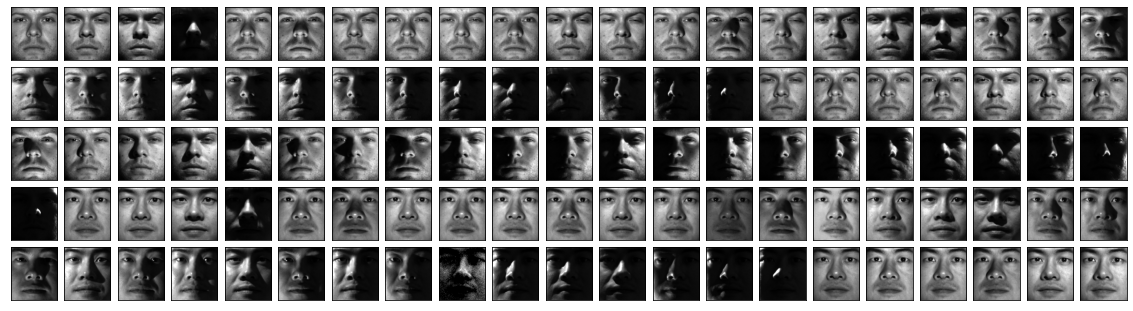

In [52]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data_yale['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [53]:
face_size_yale = [47, 47]

In [54]:
feat_data_yale, images_yale, labels_yale = [], [], []

for img, label in zip(data_yale['images'], data_yale['target']):
    # faces = faceCascade.detectMultiScale(
    #     img,
    #     scaleFactor = 1,
    #     minNeighbors = 2,
    #     minSize = (30, 30),
    #     flags = cv2.CASCADE_SCALE_IMAGE
    # )

    # iterate faces found in image
    # for (x, y, w, h) in img:
    #     new_img = img.copy()
    #
    #     # extract ROI
    #     raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
    face = cv2.resize(img, face_size_yale)
    face_flatten = face.flatten()

    images_yale.append(np.expand_dims(face, axis=-1)), feat_data_yale.append(face_flatten), labels_yale.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets_yale = label_encoder.fit_transform(labels_yale)

faces_yale = Bunch(data       = np.array(feat_data_yale),
              images     = np.array(images_yale),
              labels     = np.array(labels_yale),
              target     = np.array(targets_yale))

for key in faces_yale.keys():
    print(faces_yale[key][0:2])

[[ 79  96  99 ...  32  23  16]
 [ 90 110 117 ...  15   9   8]]
[[[[ 79]
   [ 96]
   [ 99]
   ...
   [ 88]
   [ 71]
   [ 60]]

  [[ 86]
   [ 92]
   [101]
   ...
   [ 86]
   [ 70]
   [ 59]]

  [[ 81]
   [ 94]
   [106]
   ...
   [ 83]
   [ 65]
   [ 62]]

  ...

  [[ 24]
   [ 38]
   [ 41]
   ...
   [ 38]
   [ 40]
   [ 30]]

  [[ 22]
   [ 23]
   [ 35]
   ...
   [ 53]
   [ 32]
   [ 26]]

  [[ 13]
   [ 22]
   [ 27]
   ...
   [ 32]
   [ 23]
   [ 16]]]


 [[[ 90]
   [110]
   [117]
   ...
   [100]
   [ 81]
   [ 69]]

  [[ 95]
   [102]
   [117]
   ...
   [ 98]
   [ 83]
   [ 69]]

  [[ 88]
   [108]
   [121]
   ...
   [ 96]
   [ 73]
   [ 71]]

  ...

  [[ 11]
   [ 15]
   [ 24]
   ...
   [ 29]
   [ 22]
   [ 13]]

  [[  9]
   [ 11]
   [ 14]
   ...
   [ 25]
   [ 13]
   [ 13]]

  [[  7]
   [ 10]
   [ 11]
   ...
   [ 15]
   [  9]
   [  8]]]]
['yaleB01' 'yaleB01']
[0 0]


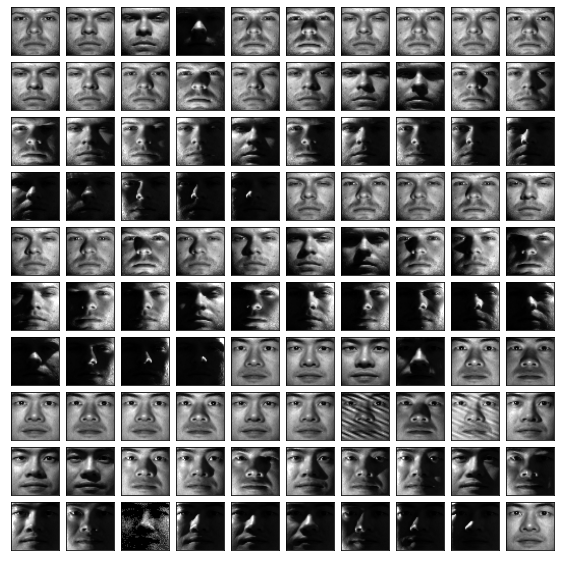

In [55]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces_yale['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [56]:
# extract number of samples and image dimensions (for later display)
imshape_yale, n_samples_yale, n_classes_yale, n_features_yale = utils.get_image_db_statistic(faces_yale)

Total dataset size:
n_samples: 2414
n_classes: 38
n_features: 2209
imshape : (47, 47, 1)


In [57]:
x_train_yale, x_test_yale, y_train_yale, y_test_yale = holdout_split(*siamese.get_siamese_paired_data(faces_yale.images, faces_yale.target))

encoder, model = siamese.create_siamese_model(imshape_yale)

rms = Adam()
model.compile(
    loss=siamese.contrastive_loss,
    optimizer=rms,
    metrics=[siamese.accuracy],
    run_eagerly=True)

epochs = 100

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit([x_train_yale[:, 0], x_train_yale[:, 1]], y_train_yale,
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs, callbacks=[cp_callback])

Epoch 1/100

Epoch 1: saving model to training_1\cp.ckpt
38/38 - 1s - loss: 0.1607 - accuracy: 0.4704 - val_loss: 0.1267 - val_accuracy: 0.5719 - 1s/epoch - 31ms/step
Epoch 2/100

Epoch 2: saving model to training_1\cp.ckpt
38/38 - 1s - loss: 0.1236 - accuracy: 0.5658 - val_loss: 0.1111 - val_accuracy: 0.6479 - 909ms/epoch - 24ms/step
Epoch 3/100

Epoch 3: saving model to training_1\cp.ckpt
38/38 - 1s - loss: 0.0911 - accuracy: 0.7327 - val_loss: 0.0873 - val_accuracy: 0.7354 - 914ms/epoch - 24ms/step
Epoch 4/100

Epoch 4: saving model to training_1\cp.ckpt
38/38 - 1s - loss: 0.0684 - accuracy: 0.8438 - val_loss: 0.0702 - val_accuracy: 0.8250 - 913ms/epoch - 24ms/step
Epoch 5/100

Epoch 5: saving model to training_1\cp.ckpt
38/38 - 1s - loss: 0.0504 - accuracy: 0.9161 - val_loss: 0.0593 - val_accuracy: 0.8813 - 875ms/epoch - 23ms/step
Epoch 6/100

Epoch 6: saving model to training_1\cp.ckpt
38/38 - 1s - loss: 0.0392 - accuracy: 0.9531 - val_loss: 0.0518 - val_accuracy: 0.9031 - 914ms/e

In [58]:
# Loads the weights
model.load_weights(checkpoint_path)

test_scores = model.predict([x_test_yale[:, 0], x_test_yale[:, 1]])
test_acc = accuracy_score(y_test_yale, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))


Accuracy on the test set: 0.952


In [59]:
transfer_system = {
    'model': model,
    'encoder': encoder
}

In [60]:
embedded_TL, dist_metric_TL = facial_descriptor.extract_face_representation(DESC=FeatureDescriptor.TL, holdout_split=holdout_split, transfer_system=transfer_system)
df_scores_TL, similarity_mat_TL = utils.compute_similarity_matrix(embedded_TL, dist_metric_TL, labels)
df_scores_TL

False
Epoch 1/10
38/38 - 1s - loss: 0.0630 - accuracy: 0.8553 - val_loss: 0.0459 - val_accuracy: 0.9292 - 862ms/epoch - 23ms/step
Epoch 2/10
38/38 - 1s - loss: 0.0304 - accuracy: 0.9613 - val_loss: 0.0354 - val_accuracy: 0.9490 - 857ms/epoch - 23ms/step
Epoch 3/10
38/38 - 1s - loss: 0.0200 - accuracy: 0.9844 - val_loss: 0.0287 - val_accuracy: 0.9729 - 847ms/epoch - 22ms/step
Epoch 4/10
38/38 - 1s - loss: 0.0144 - accuracy: 0.9934 - val_loss: 0.0244 - val_accuracy: 0.9677 - 841ms/epoch - 22ms/step
Epoch 5/10
38/38 - 1s - loss: 0.0107 - accuracy: 0.9951 - val_loss: 0.0215 - val_accuracy: 0.9729 - 859ms/epoch - 23ms/step
Epoch 6/10
38/38 - 1s - loss: 0.0081 - accuracy: 0.9967 - val_loss: 0.0189 - val_accuracy: 0.9677 - 823ms/epoch - 22ms/step
Epoch 7/10
38/38 - 1s - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.0182 - val_accuracy: 0.9792 - 824ms/epoch - 22ms/step
Epoch 8/10
38/38 - 1s - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0154 - val_accuracy: 0.9823 - 827ms/epoch - 22ms/step
Ep

100%|██████████| 440/440 [00:01<00:00, 242.33it/s]


,p1,p2,genuine,score,scores_norm
0,person_001,person_001,1,21.016870,0.966273
1,person_001,person_001,1,66.721458,0.826993
2,person_001,person_001,1,29.359577,0.940850
3,person_001,person_001,1,34.683895,0.924625
4,person_001,person_001,1,35.081810,0.923412
...,...,...,...,...,...
193155,person_026,person_026,1,14.966852,0.984710
193156,person_026,person_026,1,26.128456,0.950696
193157,person_026,person_026,1,27.874718,0.945375
193158,person_026,person_026,1,22.125956,0.962894


In [61]:
face_mat_TL = df_scores_TL.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)
face_mat_TL

p2,person_001,person_002,person_003,person_004,person_005,person_006,person_007,person_008,person_009,person_010,...,person_017,person_018,person_019,person_020,person_021,person_022,person_023,person_024,person_025,person_026
p1,,,,,,,,,,,,,,,,,,,,,
person_001,0.890670,0.680558,0.682977,0.551367,0.366109,0.631909,0.638380,0.523639,0.380246,0.585187,...,0.569447,0.756762,0.690333,0.632820,0.558401,0.621679,0.458390,0.625937,0.614653,0.721463
person_002,0.680558,0.940559,0.511184,0.777819,0.374746,0.559560,0.846273,0.607823,0.404657,0.668090,...,0.464483,0.794865,0.649443,0.678937,0.520229,0.841798,0.336737,0.637342,0.653424,0.700973
person_003,0.682977,0.511184,0.878686,0.386800,0.413490,0.595157,0.528218,0.396670,0.340108,0.485395,...,0.613168,0.620894,0.733491,0.539949,0.537586,0.499593,0.567594,0.618675,0.596449,0.581385
person_004,0.551367,0.777819,0.386800,0.929929,0.391045,0.525816,0.696342,0.724608,0.523163,0.583769,...,0.436283,0.634695,0.515765,0.614485,0.516780,0.756653,0.332174,0.615789,0.551641,0.604007
person_005,0.366109,0.374746,0.413490,0.391045,0.934750,0.267319,0.432603,0.368416,0.440845,0.232898,...,0.284789,0.449753,0.375261,0.277773,0.612149,0.449811,0.296885,0.394335,0.589488,0.528877
person_006,0.631909,0.559560,0.595157,0.525816,0.267319,0.932848,0.527322,0.583066,0.458764,0.613520,...,0.844111,0.524972,0.671668,0.741015,0.464601,0.529595,0.674959,0.727771,0.444573,0.467349
person_007,0.638380,0.846273,0.528218,0.696342,0.432603,0.527322,0.946172,0.539942,0.385965,0.596179,...,0.457455,0.770551,0.651621,0.636150,0.566937,0.875745,0.336666,0.603272,0.744289,0.719490
person_008,0.523639,0.607823,0.396670,0.724608,0.368416,0.583066,0.539942,0.916826,0.641784,0.559849,...,0.507496,0.535277,0.482172,0.622894,0.537513,0.620526,0.444876,0.663686,0.459737,0.506003
person_009,0.380246,0.404657,0.340108,0.523163,0.440845,0.458764,0.385965,0.641784,0.910144,0.345854,...,0.460836,0.370821,0.370520,0.442651,0.497907,0.451563,0.456010,0.539273,0.386981,0.420062


In [62]:
genuine_df_TL = df_scores_TL['scores_norm'][df_scores_TL['genuine'] == 1]
imposter_df_TL = df_scores_TL['scores_norm'][df_scores_TL['genuine'] == 0]

2022-05-17 18:23:52,992 - Computing precision recall
2022-05-17 18:23:53,018 - End precision recall computation curve
2022-05-17 18:23:53,018 - End precision recall computation
2022-05-17 18:23:53,019 - End f1
2022-05-17 18:23:53,019 - Computing accuracy
2022-05-17 18:23:57,891 - Generate dataframe
2022-05-17 18:23:57,900 - dataframe generated


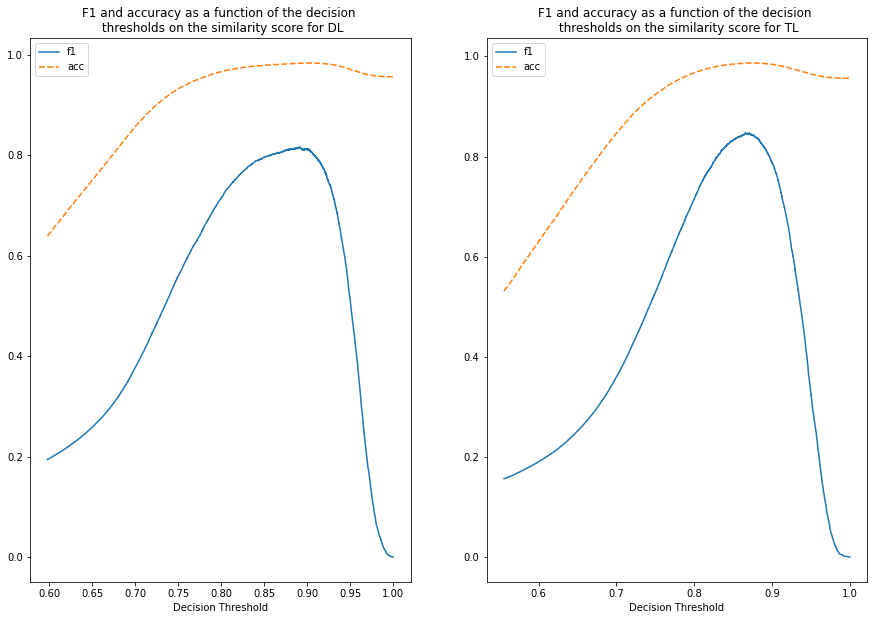

In [63]:
score_TL, y_true_TL = df_scores_TL['genuine'], df_scores_TL['scores_norm']
df_classification_metrics_TL, precision_TL, recall_TL = metrics.get_f1_and_acc_dataframe(genuine_df_TL, imposter_df_TL, score_TL, y_true_TL)
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl, "DL", axes[0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_TL, "TL", axes[1])

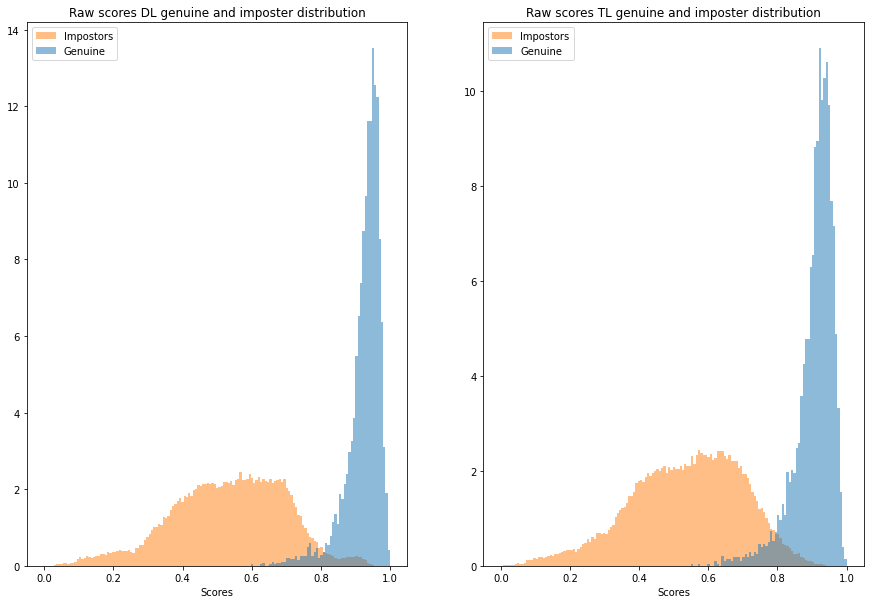

In [64]:
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_score_distribution(axes[0], imposter_df_dl, genuine_df_dl, "DL genuine and imposter distribution")
metrics.plot_score_distribution(axes[1], imposter_df_TL, genuine_df_TL, "TL genuine and imposter distribution")

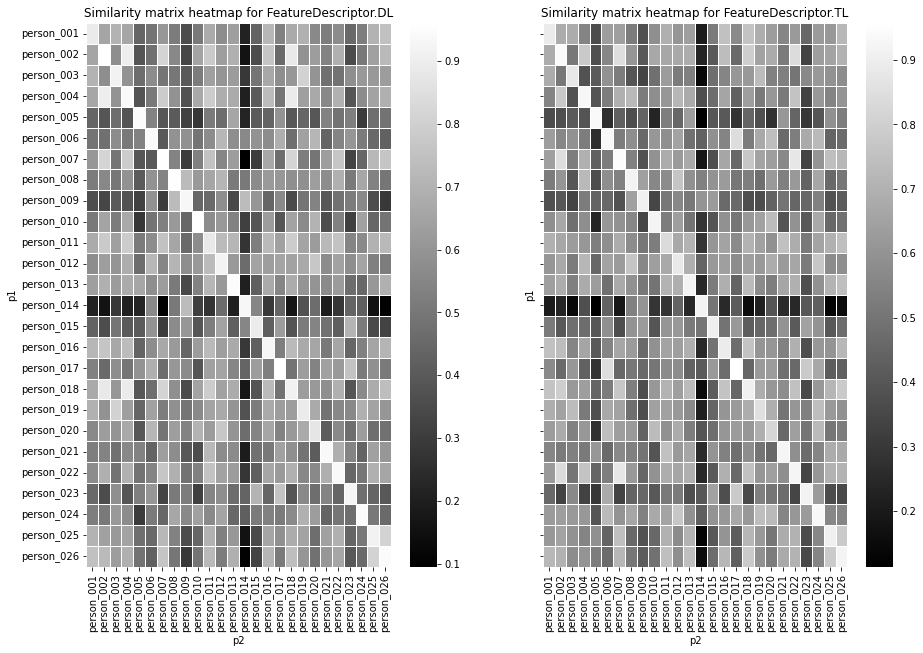

In [65]:
figure, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_dl, axes[0], FeatureDescriptor.DL)
metrics.plot_sim_matrix(face_mat_TL, axes[1], FeatureDescriptor.TL)

In [66]:
fpr_roc_TL, fnr_roc_TL, tpr_roc_TL, threshold_roc_TL = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_TL, y_true_TL)
roc_au_TL = roc_auc_score(y_true=score_TL, y_score=y_true_TL)
print('ROC score for DL : ', roc_au_dl)
print('ROC score for TL : ', roc_au_TL)

2022-05-17 18:24:04,299 - Computing roc curve
2022-05-17 18:24:04,325 - End roc curve computation


ROC score for DL :  0.9934591325241844
ROC score for TL :  0.9920263671586208


In [67]:
eer_threshold_roc_TL = threshold_roc_TL[np.nanargmin(np.absolute((fnr_roc_TL - fpr_roc_TL)))]
print('EER threshold for DL : ', eer_threshold_roc_dl)
print('EER threshold for TL : ', eer_threshold_roc_TL)

EER threshold for DL :  0.7997494906961375
EER threshold for TL :  0.7859796021752575


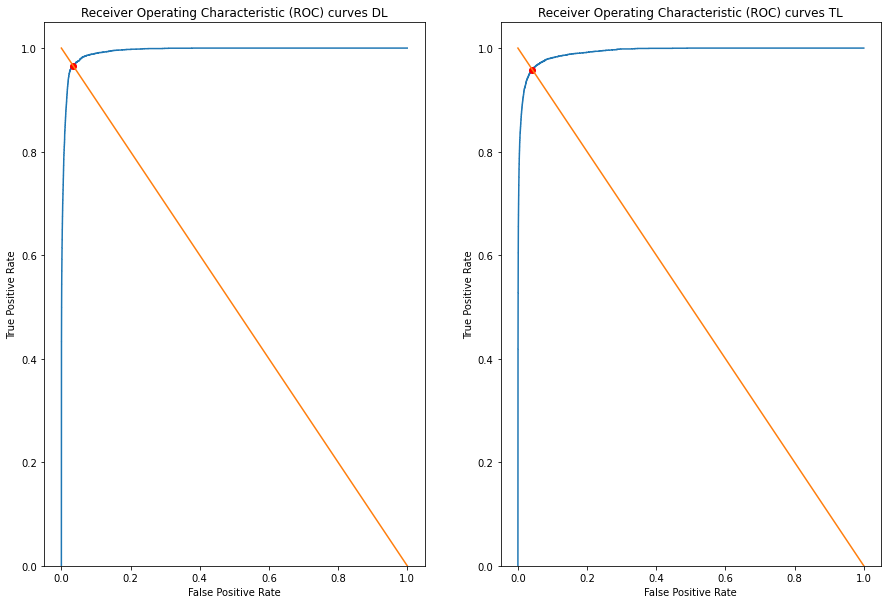

In [68]:
df_decision_threshold_fpr_fnr_TL = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_TL, tpr_roc_TL], index_values=threshold_roc_TL)
result_roc_TL = df_decision_threshold_fpr_fnr_TL.loc[eer_threshold_roc_TL]
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_roc_dl, tpr_roc_dl, axes[0], result_roc_dl, "DL")
metrics.plot_eer_roc(fpr_roc_TL, tpr_roc_TL, axes[1], result_roc_TL, "TL")

In [69]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_TL["sum"] = df_decision_threshold_fpr_fnr_TL.sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for DL', df_decision_threshold_fpr_fnr_dl["sum"].idxmin())
print('threshold for TL', df_decision_threshold_fpr_fnr_TL["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for DL 2.0
threshold for TL 2.0


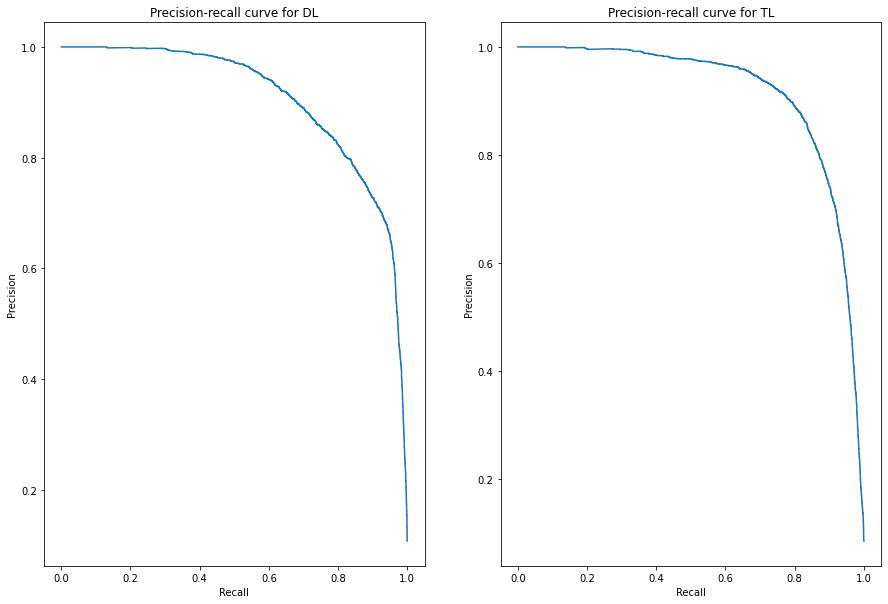

In [70]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_recall_precision(recall_dl, precision_dl, axes[0], title_add="DL")
metrics.plot_recall_precision(recall_TL, precision_TL, axes[1], title_add="TL")

In [71]:
"""Calculate the average precision scores"""
average_prec_score_TL = average_precision_score(y_true=score_TL, y_score=y_true_TL)
print('Average precision score for DL', average_prec_score_dl)
print('Average precision score for TL', average_prec_score_TL)

Average precision score for DL 0.9058686242740656
Average precision score for TL 0.9156667952831355


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


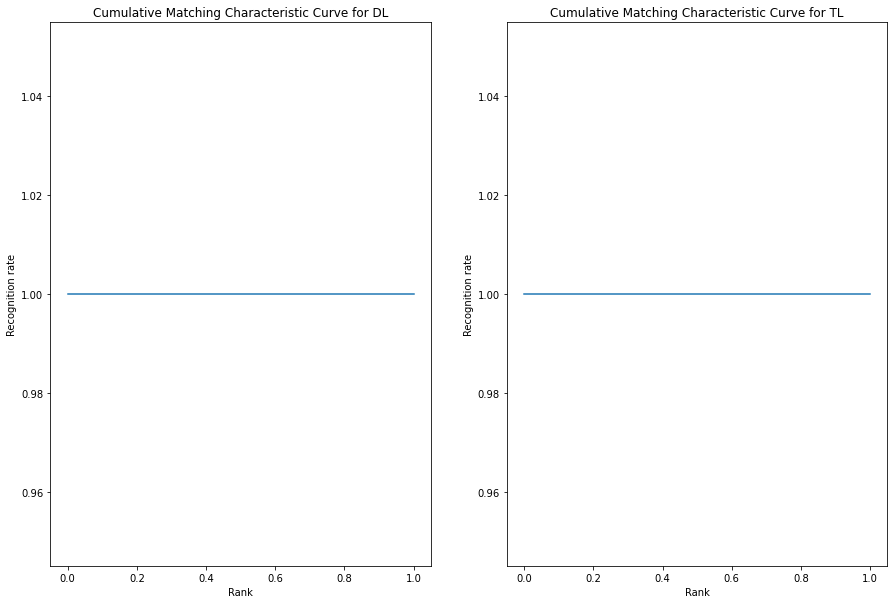

In [72]:
ranked_TL = metrics.compute_cmc(face_mat_TL)
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_cmc(ranked_dl, axes[0], "DL")
metrics.plot_cmc(ranked_TL, axes[1], "TL")

#### 2.6 Implement a different deep learning model* (2pt.)

In [202]:
# size of each face after preprocessing
face_size_nn=224

feat_data_nn, images_nn, labels_nn = [], [], []

for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()

        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, (face_size_nn, face_size_nn))
        face_flatten = face.flatten()

        images_nn.append(np.expand_dims(face, axis=-1)), feat_data_nn.append(face_flatten), labels_nn.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets_nn = label_encoder.fit_transform(labels)

faces_nn = Bunch(data       = np.array(feat_data_nn),
              images     = np.array(images_nn),
              labels     = np.array(labels_nn),
              target     = np.array(targets_nn))

for key in faces_nn.keys():
    print(faces_nn[key][0:2])

[[181 165 153 ...  74  76  84]
 [125 118 105 ...  28  32  50]]
[[[[181]
   [165]
   [153]
   ...
   [ 81]
   [ 84]
   [ 83]]

  [[193]
   [174]
   [156]
   ...
   [ 86]
   [ 82]
   [ 84]]

  [[182]
   [164]
   [117]
   ...
   [ 80]
   [ 81]
   [ 81]]

  ...

  [[113]
   [ 98]
   [ 81]
   ...
   [ 82]
   [ 83]
   [ 87]]

  [[ 93]
   [ 94]
   [ 95]
   ...
   [ 85]
   [ 74]
   [ 77]]

  [[ 93]
   [101]
   [ 83]
   ...
   [ 74]
   [ 76]
   [ 84]]]


 [[[125]
   [118]
   [105]
   ...
   [ 42]
   [ 35]
   [ 38]]

  [[128]
   [118]
   [110]
   ...
   [ 27]
   [ 22]
   [ 23]]

  [[128]
   [117]
   [109]
   ...
   [ 25]
   [ 22]
   [ 21]]

  ...

  [[ 53]
   [ 57]
   [109]
   ...
   [ 47]
   [ 83]
   [108]]

  [[ 50]
   [ 55]
   [ 99]
   ...
   [ 34]
   [ 57]
   [ 84]]

  [[ 62]
   [ 59]
   [101]
   ...
   [ 28]
   [ 32]
   [ 50]]]]
['person_001' 'person_001']
[0 0]


In [203]:
x_train_nn, x_test_nn, y_train_nn, y_test_nn = holdout_split(faces_nn.images, faces_nn.target)
x_train_nn = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in x_train_nn])
x_test_nn = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in x_test_nn])
images_nn = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in faces_nn.images])

In [208]:
data_processor = DataPreProcessor(images_train_x=x_train_nn, images_train_y=y_train_nn, images_test_x=x_test_nn, images_test_y=y_test_nn, batch_size=16, n_classes=n_classes)
train_set = data_processor.get_train_set
val_set = data_processor.get_val_set
test_set = data_processor.get_test_set

In [209]:
train_set.x[0].shape

(224, 224, 3)

In [210]:
# !pip install keras_vggface
# !pip install keras_applications --no-deps
filename="C:/Users/harol/miniconda3/envs/biometrics37/Lib/site-packages/keras_vggface/models.py"
# filename = "/opt/conda/lib/python3.7/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

In [212]:
from src.neuralnetwork import ClassificationModel, TransferModels

In [213]:
# adam, rmsprop, nadam,
model_dashboard = ClassificationModel(optimiser='rmsprop', input_size=(face_size_nn, face_size_nn, 3), n_classes=data_processor.n_classes)
model_choice = 'vgg16_resnet'
model_dashboard.compute_model(transfer_model=TransferModels.resnet50_vggface, pretrained=True, vggface=True)

ic| len(tf_model.layers): 175


Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

In [214]:
model_dashboard.fit(train_set, val_set, model_choice=model_choice, epochs=100)

best_weights_{epoch:02d}-{val_accuracy:.2f}.hdf5
Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.0505
Epoch 1: val_loss improved from inf to 0.16566, saving model to output/vgg16_resnet\best_weights_01-0.05.hdf5
19/19 [==============================] - 8s 325ms/step - loss: 0.1869 - accuracy: 0.0505 - val_loss: 0.1657 - val_accuracy: 0.0539 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.0337
Epoch 2: val_loss improved from 0.16566 to 0.16108, saving model to output/vgg16_resnet\best_weights_02-0.06.hdf5
19/19 [==============================] - 5s 272ms/step - loss: 0.1691 - accuracy: 0.0337 - val_loss: 0.1611 - val_accuracy: 0.0572 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.0404
Epoch 3: val_loss did not improve from 0.16108
19/19 [==============================] - 5s 255ms/step - loss: 0.1684 - accuracy: 0.0404 - val_loss: 0.1658

In [215]:
model_dashboard.plot_accuracy_and_loss_plt()

TypeError: 'module' object is not callable

In [216]:
model_vgg = model_dashboard.get_model
print(model_vgg.summary())
vgg_face_descriptor = Model(inputs=model_vgg.layers[0].input
, outputs=model_vgg.layers[-2].output)
vgg_face_descriptor.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

In [217]:
embedded_nn = vgg_face_descriptor(images_nn).numpy()
dist_metric_nn = euclidean

In [218]:
df_scores_nn, similarity_mat_nn = utils.compute_similarity_matrix(embedded_nn, dist_metric_nn, labels_nn)

face_mat_nn = df_scores_nn.pivot_table(index='p1', columns='p2',values='scores_norm',aggfunc = np.average)

genuine_df_nn = df_scores_nn['scores_norm'][df_scores_nn['genuine'] == 1]
imposter_df_nn = df_scores_nn['scores_norm'][df_scores_nn['genuine'] == 0]

100%|██████████| 440/440 [00:02<00:00, 209.23it/s]


2022-05-20 17:32:51,147 - Computing precision recall
2022-05-20 17:32:51,174 - End precision recall computation curve
2022-05-20 17:32:51,175 - End precision recall computation
2022-05-20 17:32:51,176 - End f1
2022-05-20 17:32:51,177 - Computing accuracy
2022-05-20 17:33:00,795 - Generate dataframe
2022-05-20 17:33:00,810 - dataframe generated


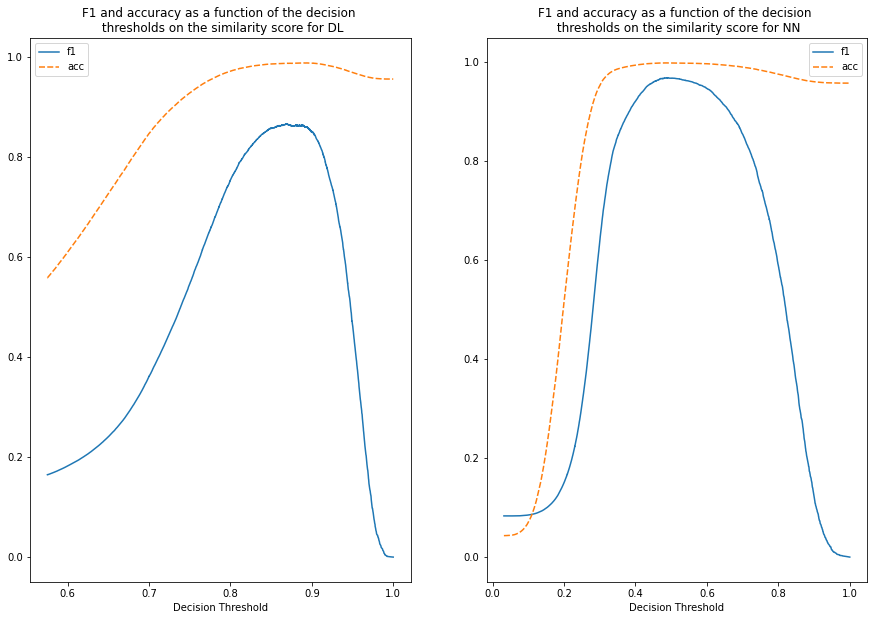

In [219]:
score_nn, y_true_nn = df_scores_nn['genuine'], df_scores_nn['scores_norm']
df_classification_metrics_nn, precision_nn, recall_nn = metrics.get_f1_and_acc_dataframe(genuine_df_nn, imposter_df_nn, score_nn, y_true_nn)
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_dl, "DL", axes[0])
metrics.plot_decision_threshold_f1_acc(df_classification_metrics_nn, "NN", axes[1])

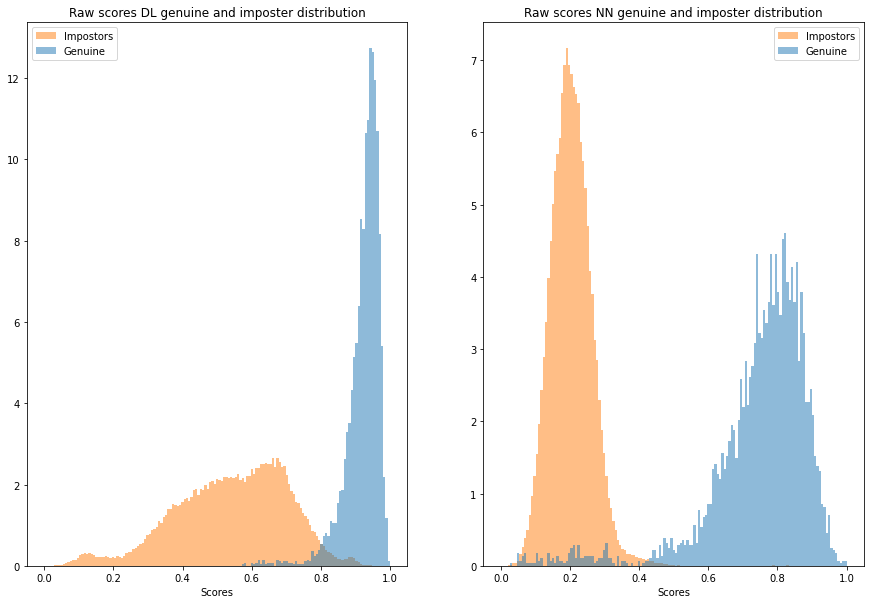

In [220]:
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_score_distribution(axes[0], imposter_df_dl, genuine_df_dl, "DL genuine and imposter distribution")
metrics.plot_score_distribution(axes[1], imposter_df_nn, genuine_df_nn, "NN genuine and imposter distribution")

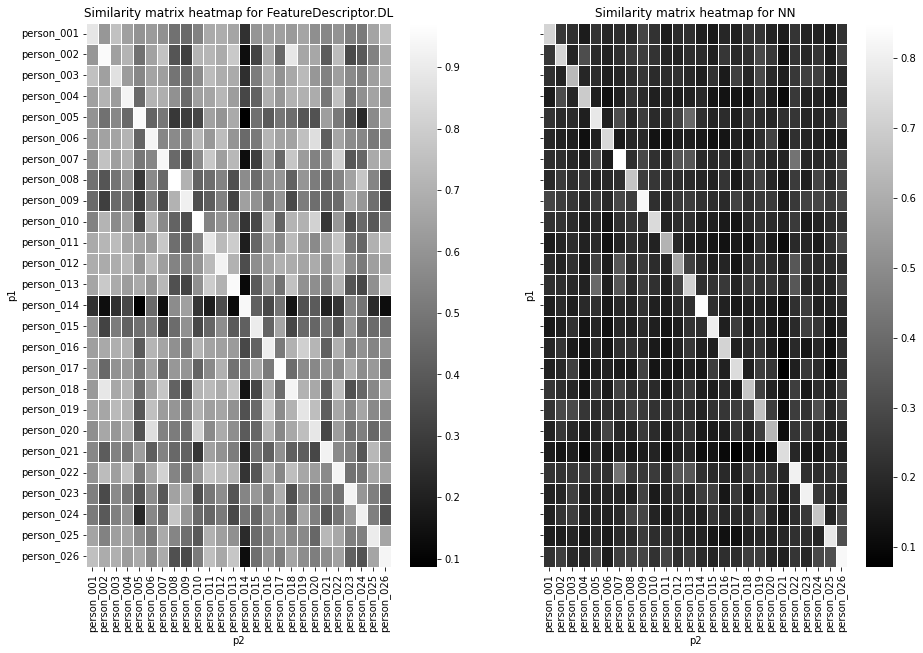

In [221]:
figure, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)
metrics.plot_sim_matrix(face_mat_dl, axes[0], FeatureDescriptor.DL)
metrics.plot_sim_matrix(face_mat_nn, axes[1], "NN")

In [222]:
fpr_roc_nn, fnr_roc_nn, tpr_roc_nn, threshold_roc_nn = metrics.compute_fpr_fnr_tpr_from_roc_curve(score_nn, y_true_nn)
roc_au_nn = roc_auc_score(y_true=score_nn, y_score=y_true_nn)
print('ROC score for DL : ', roc_au_dl)
print('ROC score for NN : ', roc_au_nn)

2022-05-20 17:33:10,827 - Computing roc curve
2022-05-20 17:33:10,853 - End roc curve computation


ROC score for DL :  0.9946904052353734
ROC score for NN :  0.9839437604676226


In [223]:
eer_threshold_roc_nn = threshold_roc_nn[np.nanargmin(np.absolute((fnr_roc_nn - fpr_roc_nn)))]
print('EER threshold for DL : ', eer_threshold_roc_dl)
print('EER threshold for NN : ', eer_threshold_roc_nn)

EER threshold for DL :  0.8038245418032111
EER threshold for NN :  0.3154757865567719


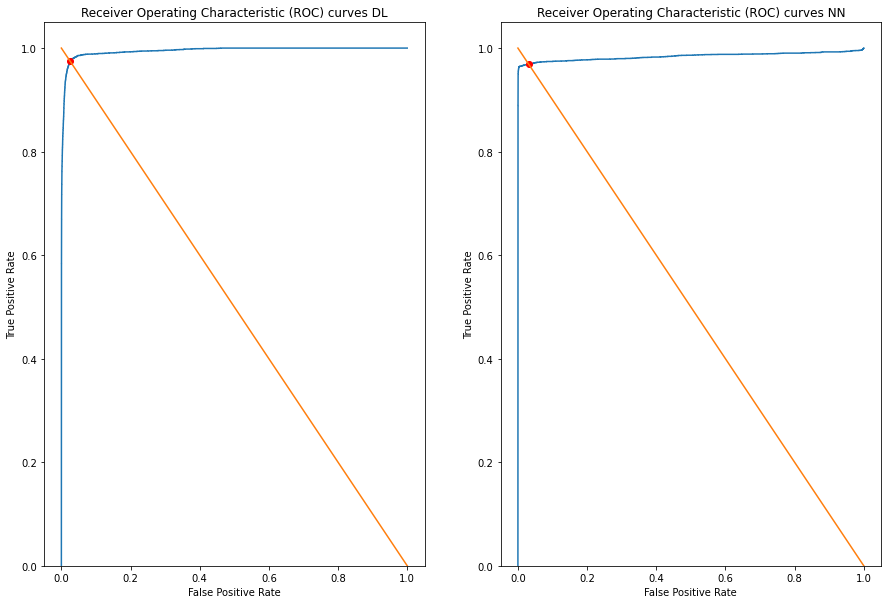

In [224]:
df_decision_threshold_fpr_fnr_nn = metrics.generate_dataframe(columns=['fpr', 'tpr'], data_list=[fpr_roc_nn, tpr_roc_nn], index_values=threshold_roc_nn)
result_roc_nn = df_decision_threshold_fpr_fnr_nn.loc[eer_threshold_roc_nn]
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_roc_dl, tpr_roc_dl, axes[0], result_roc_dl, "DL")
metrics.plot_eer_roc(fpr_roc_nn, tpr_roc_nn, axes[1], result_roc_nn, "NN")

In [225]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
df_decision_threshold_fpr_fnr_nn["sum"] = df_decision_threshold_fpr_fnr_nn.sum(axis=1)

print('Decision threshold where sum of frr and far are minimal')
print('threshold for DL', df_decision_threshold_fpr_fnr_dl["sum"].idxmin())
print('threshold for NN', df_decision_threshold_fpr_fnr_nn["sum"].idxmin())

Decision threshold where sum of frr and far are minimal
threshold for DL 2.0
threshold for NN 2.0


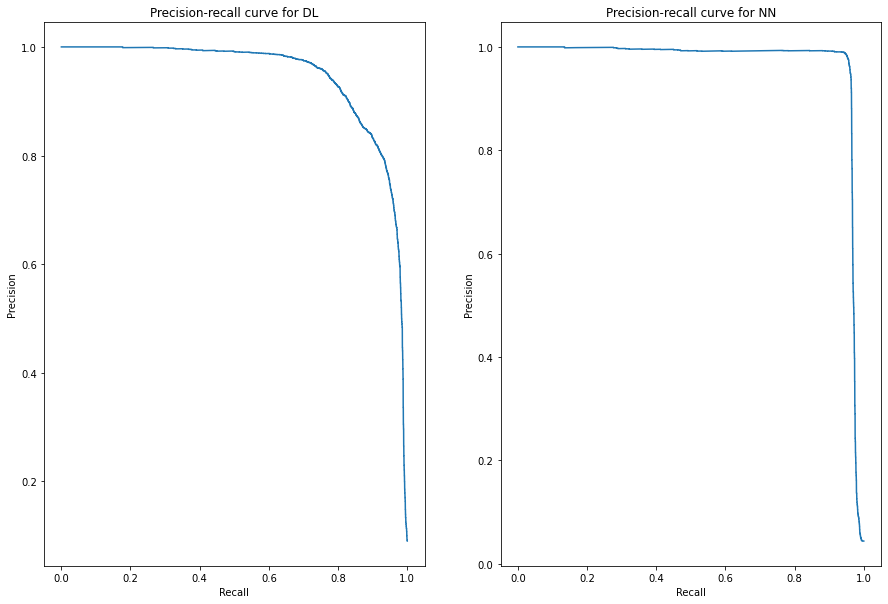

In [226]:
"""Calculate and plot the Precision-Recall curve for this system"""
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_recall_precision(recall_dl, precision_dl, axes[0], title_add="DL")
metrics.plot_recall_precision(recall_nn, precision_nn, axes[1], title_add="NN")

In [227]:
"""Calculate the average precision scores"""
average_prec_score_nn = average_precision_score(y_true=score_nn, y_score=y_true_nn)
print('Average precision score for DL', average_prec_score_dl)
print('Average precision score for NN', average_prec_score_nn)

Average precision score for DL 0.9459504108789053
Average precision score for NN 0.9673156515794012


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


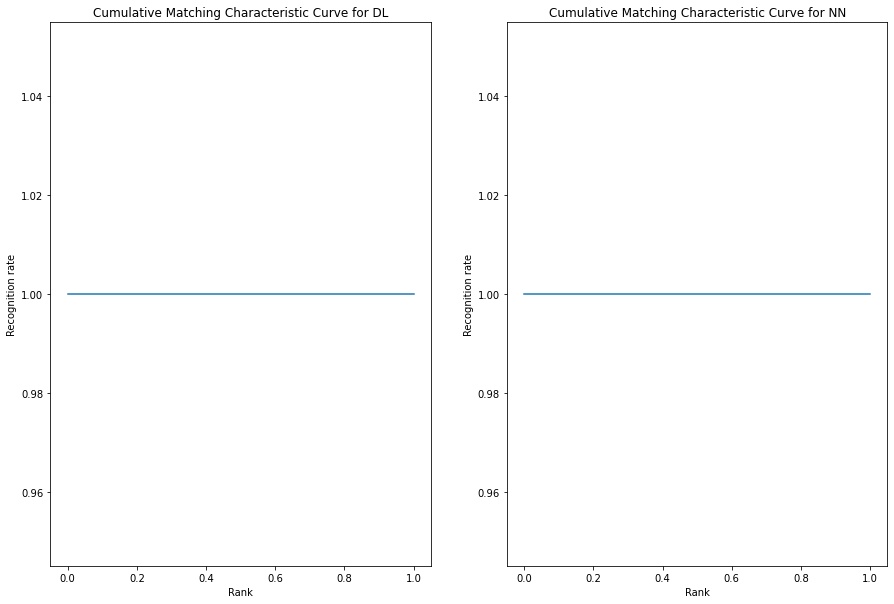

In [228]:
ranked_nn = metrics.compute_cmc(face_mat_nn)
figure, axes = plt.subplots(1, 2, figsize=(15, 10))
metrics.plot_cmc(ranked_dl, axes[0], "DL")
metrics.plot_cmc(ranked_nn, axes[1], "NN")

## Fine tuning
doesn't improve the model

In [229]:
# model_tf = model_dashboard.get_model
# model_tf = model_dashboard.activate_training_layers(model_tf, 18)
# model_dashboard.set_model(model_tf)
# model_dashboard.compile_model(opt=Adam(1e-5)) ## slow learning

In [230]:
# model_dashboard.fit(train_set, val_set, model_choice=model_choice, epochs=30, fine_tuning=True)

In [231]:
# model_dashboard.plot_accuracy_and_loss_plt()